# Hand Gesture Classification using EMG

**EMG Pattern Classification**

For recording patterns, the authors (1) used a MYO Thalmic bracelet worn on a user’s forearm, and a PC with a Bluetooth receiver. The bracelet is equipped with **eight sensors** equally spaced around the forearm that simultaneously acquire myographic signals. The signals are sent through a Bluetooth interface to a PC. 


    Author: Debanjan Saha
    College: Northeastern University
    Group: Project Group 7
    Batch: Wednesday
    Course: IE 7300
    Professor: Ramin M.

This dataset contains raw EMG data for **36** subjects while they performed series of static hand gestures.The subject performs two series, each of which consists of **six (seven) basic gestures**. Each gesture was **performed for 3 seconds** with a **pause** of **3 seconds between gestures**.

**Relevant Papers**:
1. Lobov S., Krilova N., Kastalskiy I., Kazantsev V., Makarov V.A. Latent Factors Limiting the Performance of sEMG-Interfaces. Sensors. 2018;18(4):1122. doi: 10.3390/s18041122

2. Côté Allard, Ulysse & Fall, C. L. & Campeau-Lecours, Alexandre & Gosselin, Clément & Laviolette, Francois & Gosselin, Benoit. (2017). Transfer Learning for sEMG Hand Gesture Recognition Using Convolutional Neural Networks. 10.1109/SMC.2017.8122854.


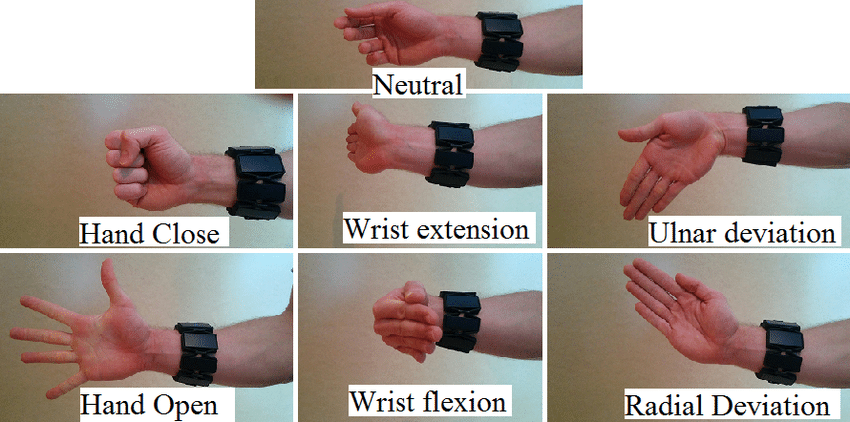

Image Source: Allard et. al (2)

## Import Libraries

In [1]:
!pip install nolds
!pip install pycatch22
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 994.5 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.2-cp39-cp39-linux_x86_64.whl size=118677 sha256=b581e52538e5a8e1897a67167251c22fe184b70030c8a8c958a8e409dc6d1bff
  Stored in directory: /root/.cache/pip/wheels/c0/84/da/f210e9de22c6265163dac19287b0674e040605dfc519d83ca5
Successfully built pycatch22
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import operator
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pywt
import librosa
import nolds
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
from numpy.lib.stride_tricks import sliding_window_view
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 500)

In [3]:
import statistics
from scipy import stats
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt, find_peaks
import pycatch22
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

In [4]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master'
!ls -lrt

/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master
total 96636
-rw------- 1 root root     1453 Dec  7  2018 README.txt
drwx------ 2 root root     4096 Apr  2 17:32 25
drwx------ 2 root root     4096 Apr  2 17:32 24
drwx------ 2 root root     4096 Apr  2 17:32 23
drwx------ 2 root root     4096 Apr  2 17:32 22
drwx------ 2 root root     4096 Apr  2 17:32 15
drwx------ 2 root root     4096 Apr  2 17:32 14
drwx------ 2 root root     4096 Apr  2 17:32 13
drwx------ 2 root root     4096 Apr  2 17:32 12
drwx------ 2 root root     4096 Apr  2 17:32 06
drwx------ 2 root root     4096 Apr  2 17:32 01
drwx------ 2 root root     4096 Apr  2 17:32 36
drwx------ 2 root root     4096 Apr  2 17:32 31
drwx------ 2 root root     4096 Apr  2 17:32 30
drwx------ 2 root root     4096 Apr  2 17:32 26
drwx------ 2 root root     4096 Apr  2 17:32 21
drwx------ 2 root root     4096 Apr  2 17:32 19
drwx------ 2 root root     4096 Apr  2 17:32 10
drwx------ 2 root root     

## Read Data

In [6]:
# List out all the available files in the project's environment
files_path = set()
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/'):
    for filename in filenames:
        f_path = os.path.join(dirname, filename)
        files_path.add(f_path)

In [7]:
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/README.txt')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/all_ext_features_data.csv')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/Segmented_Catch22_Subject1.csv')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/catch22_freq_dm.csv')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/.DS_Store')
files_path

{'/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/2_raw_data_13-13_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/1_raw_data_14-19_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/2_raw_data_14-21_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/1_raw_data_09-32_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/2_raw_data_09-34_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/1_raw_data_18-02_24.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/2_raw_data_18-03_24.04.1

In [8]:
all_train = pd.DataFrame()
all_test = pd.DataFrame()
for id, file in enumerate(tqdm(sorted(files_path))):
    
    sub = int(file.split('/')[-2])
    data = pd.read_csv(file, sep='\t')
    subject_id = np.ones([len(data),1], dtype=np.int16)*sub
    print('\tSubject Id: \t', sub, '\tShape: ', subject_id.shape)
    # Add the subject into the data
    data['subject_id'] = subject_id
    if id%2 == 1: 
        all_train = pd.concat([all_train, data], axis=0, ignore_index=True, copy=True)
    else:
        all_test = pd.concat([all_test, data], axis=0, ignore_index=True, copy=True)

print('Total Training Records: ', all_train.shape)
print('Total Testing Records: ', all_test.shape)

  1%|▏         | 1/72 [00:00<00:57,  1.23it/s]

	Subject Id: 	 1 	Shape:  (63196, 1)


  3%|▎         | 2/72 [00:01<00:53,  1.32it/s]

	Subject Id: 	 1 	Shape:  (57974, 1)


  4%|▍         | 3/72 [00:02<00:51,  1.33it/s]

	Subject Id: 	 2 	Shape:  (72322, 1)


  6%|▌         | 4/72 [00:02<00:49,  1.36it/s]

	Subject Id: 	 2 	Shape:  (64104, 1)


  7%|▋         | 5/72 [00:03<00:48,  1.37it/s]

	Subject Id: 	 3 	Shape:  (56568, 1)


  8%|▊         | 6/72 [00:04<00:46,  1.42it/s]

	Subject Id: 	 3 	Shape:  (49217, 1)


 10%|▉         | 7/72 [00:05<00:45,  1.42it/s]

	Subject Id: 	 4 	Shape:  (59107, 1)


 11%|█         | 8/72 [00:05<00:43,  1.46it/s]

	Subject Id: 	 4 	Shape:  (55091, 1)


 12%|█▎        | 9/72 [00:06<00:43,  1.44it/s]

	Subject Id: 	 5 	Shape:  (57118, 1)


 14%|█▍        | 10/72 [00:07<00:41,  1.50it/s]

	Subject Id: 	 5 	Shape:  (50130, 1)


 15%|█▌        | 11/72 [00:07<00:41,  1.48it/s]

	Subject Id: 	 6 	Shape:  (51078, 1)


 17%|█▋        | 12/72 [00:08<00:39,  1.50it/s]

	Subject Id: 	 6 	Shape:  (48541, 1)


 18%|█▊        | 13/72 [00:09<00:40,  1.46it/s]

	Subject Id: 	 7 	Shape:  (68697, 1)


 19%|█▉        | 14/72 [00:09<00:39,  1.47it/s]

	Subject Id: 	 7 	Shape:  (63943, 1)


 21%|██        | 15/72 [00:10<00:38,  1.47it/s]

	Subject Id: 	 8 	Shape:  (60280, 1)


 22%|██▏       | 16/72 [00:11<00:38,  1.46it/s]

	Subject Id: 	 8 	Shape:  (57668, 1)


 24%|██▎       | 17/72 [00:11<00:38,  1.41it/s]

	Subject Id: 	 9 	Shape:  (62770, 1)


 25%|██▌       | 18/72 [00:12<00:37,  1.45it/s]

	Subject Id: 	 9 	Shape:  (64877, 1)


 26%|██▋       | 19/72 [00:13<00:36,  1.44it/s]

	Subject Id: 	 10 	Shape:  (61641, 1)


 28%|██▊       | 20/72 [00:14<00:37,  1.38it/s]

	Subject Id: 	 10 	Shape:  (61448, 1)


 29%|██▉       | 21/72 [00:14<00:36,  1.38it/s]

	Subject Id: 	 11 	Shape:  (74681, 1)


 31%|███       | 22/72 [00:15<00:36,  1.38it/s]

	Subject Id: 	 11 	Shape:  (72645, 1)


 32%|███▏      | 23/72 [00:16<00:35,  1.37it/s]

	Subject Id: 	 12 	Shape:  (65920, 1)


 33%|███▎      | 24/72 [00:16<00:34,  1.40it/s]

	Subject Id: 	 12 	Shape:  (62631, 1)


 35%|███▍      | 25/72 [00:17<00:33,  1.42it/s]

	Subject Id: 	 13 	Shape:  (75676, 1)


 36%|███▌      | 26/72 [00:18<00:33,  1.37it/s]

	Subject Id: 	 13 	Shape:  (77564, 1)


 38%|███▊      | 27/72 [00:19<00:32,  1.38it/s]

	Subject Id: 	 14 	Shape:  (52821, 1)


 39%|███▉      | 28/72 [00:19<00:31,  1.41it/s]

	Subject Id: 	 14 	Shape:  (48182, 1)


 40%|████      | 29/72 [00:20<00:30,  1.41it/s]

	Subject Id: 	 15 	Shape:  (53553, 1)


 42%|████▏     | 30/72 [00:21<00:29,  1.40it/s]

	Subject Id: 	 15 	Shape:  (51843, 1)


 43%|████▎     | 31/72 [00:21<00:28,  1.44it/s]

	Subject Id: 	 16 	Shape:  (55489, 1)


 44%|████▍     | 32/72 [00:22<00:27,  1.43it/s]

	Subject Id: 	 16 	Shape:  (50012, 1)


 46%|████▌     | 33/72 [00:23<00:27,  1.43it/s]

	Subject Id: 	 17 	Shape:  (65227, 1)


 47%|████▋     | 34/72 [00:23<00:26,  1.44it/s]

	Subject Id: 	 17 	Shape:  (66858, 1)


 49%|████▊     | 35/72 [00:24<00:26,  1.40it/s]

	Subject Id: 	 18 	Shape:  (62354, 1)


 50%|█████     | 36/72 [00:25<00:25,  1.39it/s]

	Subject Id: 	 18 	Shape:  (66958, 1)


 51%|█████▏    | 37/72 [00:26<00:25,  1.37it/s]

	Subject Id: 	 19 	Shape:  (58818, 1)


 53%|█████▎    | 38/72 [00:26<00:24,  1.39it/s]

	Subject Id: 	 19 	Shape:  (51088, 1)


 54%|█████▍    | 39/72 [00:27<00:23,  1.42it/s]

	Subject Id: 	 20 	Shape:  (65349, 1)


 56%|█████▌    | 40/72 [00:28<00:22,  1.44it/s]

	Subject Id: 	 20 	Shape:  (62504, 1)


 57%|█████▋    | 41/72 [00:28<00:21,  1.42it/s]

	Subject Id: 	 21 	Shape:  (62365, 1)


 58%|█████▊    | 42/72 [00:29<00:22,  1.35it/s]

	Subject Id: 	 21 	Shape:  (56882, 1)


 60%|█████▉    | 43/72 [00:30<00:21,  1.37it/s]

	Subject Id: 	 22 	Shape:  (61788, 1)


 61%|██████    | 44/72 [00:31<00:19,  1.41it/s]

	Subject Id: 	 22 	Shape:  (57841, 1)


 62%|██████▎   | 45/72 [00:31<00:19,  1.42it/s]

	Subject Id: 	 23 	Shape:  (60135, 1)


 64%|██████▍   | 46/72 [00:32<00:18,  1.43it/s]

	Subject Id: 	 23 	Shape:  (55484, 1)


 65%|██████▌   | 47/72 [00:33<00:17,  1.41it/s]

	Subject Id: 	 24 	Shape:  (61968, 1)


 67%|██████▋   | 48/72 [00:33<00:16,  1.45it/s]

	Subject Id: 	 24 	Shape:  (54972, 1)


 68%|██████▊   | 49/72 [00:34<00:15,  1.46it/s]

	Subject Id: 	 25 	Shape:  (62681, 1)


 69%|██████▉   | 50/72 [00:35<00:14,  1.49it/s]

	Subject Id: 	 25 	Shape:  (54066, 1)


 71%|███████   | 51/72 [00:35<00:14,  1.47it/s]

	Subject Id: 	 26 	Shape:  (56151, 1)


 72%|███████▏  | 52/72 [00:36<00:13,  1.48it/s]

	Subject Id: 	 26 	Shape:  (50003, 1)


 74%|███████▎  | 53/72 [00:37<00:13,  1.46it/s]

	Subject Id: 	 27 	Shape:  (56688, 1)


 75%|███████▌  | 54/72 [00:38<00:13,  1.32it/s]

	Subject Id: 	 27 	Shape:  (50111, 1)
	Subject Id: 	 28 	Shape:  (50513, 1)


 78%|███████▊  | 56/72 [00:40<00:14,  1.11it/s]

	Subject Id: 	 28 	Shape:  (47253, 1)
	Subject Id: 	 29 	Shape:  (53904, 1)


 81%|████████  | 58/72 [00:42<00:12,  1.09it/s]

	Subject Id: 	 29 	Shape:  (52083, 1)


 82%|████████▏ | 59/72 [00:43<00:11,  1.11it/s]

	Subject Id: 	 30 	Shape:  (77878, 1)


 83%|████████▎ | 60/72 [00:44<00:10,  1.11it/s]

	Subject Id: 	 30 	Shape:  (70683, 1)


 85%|████████▍ | 61/72 [00:44<00:09,  1.13it/s]

	Subject Id: 	 31 	Shape:  (44927, 1)


 86%|████████▌ | 62/72 [00:45<00:08,  1.14it/s]

	Subject Id: 	 31 	Shape:  (46096, 1)


 88%|████████▊ | 63/72 [00:46<00:08,  1.10it/s]

	Subject Id: 	 32 	Shape:  (62719, 1)


 89%|████████▉ | 64/72 [00:47<00:06,  1.15it/s]

	Subject Id: 	 32 	Shape:  (60211, 1)
	Subject Id: 	 33 	Shape:  (59017, 1)


 92%|█████████▏| 66/72 [00:49<00:05,  1.19it/s]

	Subject Id: 	 33 	Shape:  (53088, 1)


 93%|█████████▎| 67/72 [00:49<00:04,  1.25it/s]

	Subject Id: 	 34 	Shape:  (79765, 1)


 94%|█████████▍| 68/72 [00:50<00:03,  1.31it/s]

	Subject Id: 	 34 	Shape:  (51438, 1)


 96%|█████████▌| 69/72 [00:51<00:02,  1.36it/s]

	Subject Id: 	 35 	Shape:  (50417, 1)


 97%|█████████▋| 70/72 [00:51<00:01,  1.37it/s]

	Subject Id: 	 35 	Shape:  (49084, 1)


 99%|█████████▊| 71/72 [00:52<00:00,  1.36it/s]

	Subject Id: 	 36 	Shape:  (52390, 1)


100%|██████████| 72/72 [00:53<00:00,  1.35it/s]

	Subject Id: 	 36 	Shape:  (49364, 1)
Total Training Records:  (2041937, 11)
Total Testing Records:  (2195971, 11)


In [9]:
all_train.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
1,6,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
2,7,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
3,8,-0.00003,-0.00005,-0.00008,-0.00004,-0.00003,0.00000,-0.00002,0.00000,0,1
4,9,-0.00003,-0.00001,0.00000,0.00001,-0.00001,0.00000,0.00000,-0.00002,0,1


In [10]:
all_test.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1


## Data Exploration
The data has the target variable `class` which can have values from 1 to 7, whereas, the data `class = 0` is unmarked data, which we have to infer with the model which has learned the gestures.

Here are the following gesture descriptions:
0. unmarked data,
1. hand at rest, 
2. hand clenched in a fist, 
3. wrist flexion,
4. wrist extension,
5. radial deviations,
6. ulnar deviations,
7. extended palm (the gesture was not performed by all subjects).

The data contains gesture class marked as 0 as an unsupervised classification problem. So, we shall be using the labeled data for our analysis.
So we can split the data into training and testing sets based on this `class` column, where all data for class = 0 will be our holdout data, and the labeled data will be for classes = 1,2,3,4,5,6, and 7.



In [11]:
print(all_test.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         1
subject_id    0
dtype: int64


In [12]:
# Dropping null values because there is only one nan value
all_test = all_test.dropna()

In [13]:
# Check for missing values
print(all_test.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64


In [14]:
# Check for outliers
print(all_train.describe())

               time      channel1      channel2      channel3      channel4  \
count  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06   
mean   2.997360e+04 -8.167568e-06 -9.512287e-06 -9.612495e-06 -9.633035e-06   
std    1.797005e+04  1.634088e-04  1.178507e-04  1.206633e-04  2.273340e-04   
min    1.000000e+00 -1.280000e-03 -1.280000e-03 -1.280000e-03 -1.280000e-03   
25%    1.472400e+04 -3.000000e-05 -4.000000e-05 -4.000000e-05 -6.000000e-05   
50%    2.941300e+04 -1.000000e-05 -1.000000e-05 -1.000000e-05 -1.000000e-05   
75%    4.411400e+04  2.000000e-05  2.000000e-05  3.000000e-05  4.000000e-05   
max    8.135700e+04  1.270000e-03  1.270000e-03  1.270000e-03  1.270000e-03   

           channel5      channel6      channel7      channel8         class  \
count  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06   
mean  -1.639132e-05 -1.065175e-05 -9.494269e-06 -1.013566e-05  1.316184e+00   
std    2.775514e-04  2.160535e-04  1.527449e-04  1.

In [15]:
all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041937 entries, 0 to 2041936
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   time        int64  
 1   channel1    float64
 2   channel2    float64
 3   channel3    float64
 4   channel4    float64
 5   channel5    float64
 6   channel6    float64
 7   channel7    float64
 8   channel8    float64
 9   class       int64  
 10  subject_id  int16  
dtypes: float64(8), int16(1), int64(2)
memory usage: 159.7 MB


### The metadata describes class 0 as unlabelled. We are interested in classification. Hence we decided to drop class 0.
### Holdout Data

In [16]:
holdout_data_train = all_train.loc[all_train['class'] == 0]
holdout_data_test = all_test.loc[all_test['class'] == 0]
holdout_data = pd.concat([holdout_data_train, holdout_data_test], axis=0)
holdout_data = holdout_data.reset_index(drop=True)

### Train Test Split

The overall data is collected for 36 subjects, who perform a series of gestures with an interval of 3 seconds. These subjects perform these activities twice. For the sake of consistency, we will consider the first trial as our training data and the second trial as our test data. Also, the data contains unmarked gestures (class = 0), which we have separated out as holdout.

The class 7 is performed only be 2 subjects. We have decided to drop it, to maintian a balanced dataset

In [17]:
labeled_train = all_train.loc[(all_train['class'] != 0) & (all_train['class'] != 7)]
labeled_train = labeled_train.reset_index(drop=True)

labeled_test = all_test.loc[(all_test['class'] != 0) & (all_test['class'] != 7)]
labeled_test = labeled_test.reset_index(drop=True)

In [18]:
print("Labeled Train Shape: ", labeled_train.shape)
labeled_train

Labeled Train Shape:  (748081, 11)


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
1,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
2,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
3,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
4,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
...,...,...,...,...,...,...,...,...,...,...,...
748076,50226,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
748077,50227,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
748078,50228,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
748079,50229,0.00014,0.00003,-0.00001,0.00001,-0.00012,0.00006,-0.00007,-0.00013,6,36


In [19]:
labeled_test

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2400,-0.00001,0.00000,-0.00001,0.00000,0.00000,-0.00001,-0.00001,0.00001,1.0,1
1,2401,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
2,2402,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
3,2403,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
4,2404,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
750968,53577,0.00001,0.00000,-0.00002,0.00002,-0.00010,0.00004,-0.00003,-0.00004,6.0,36
750969,53578,0.00001,0.00000,-0.00002,0.00002,-0.00010,0.00004,-0.00003,-0.00004,6.0,36
750970,53579,0.00005,0.00002,0.00000,0.00000,-0.00005,-0.00005,-0.00004,-0.00001,6.0,36
750971,53580,0.00005,0.00002,0.00000,0.00000,-0.00005,-0.00005,-0.00004,-0.00001,6.0,36


#### Plot Data

In [20]:
def plot_labeled_data(df, str_title):
    # Create a dictionary of gestures and their corresponding colors
    gesture_colors = {1: 'blue', 2: 'orange', 3: 'green', 4: 'red', 5: 'purple', 6: 'brown', 7: 'pink'}

    plt.figure(figsize=(25,8))
    # Iterate through each gesture and plot it with a different color
    for gesture in gesture_colors:
        gesture_data = df[df['class'] == gesture].iloc[:, 1:8].mean(axis=1)
        plt.plot(gesture_data, color=gesture_colors[gesture], label=f'Gesture {gesture}')

    # Add a legend and set the title and axis labels
    plt.title(str_title)
    plt.xlabel('Time (ms)')
    plt.ylabel('EMG Signal')
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()

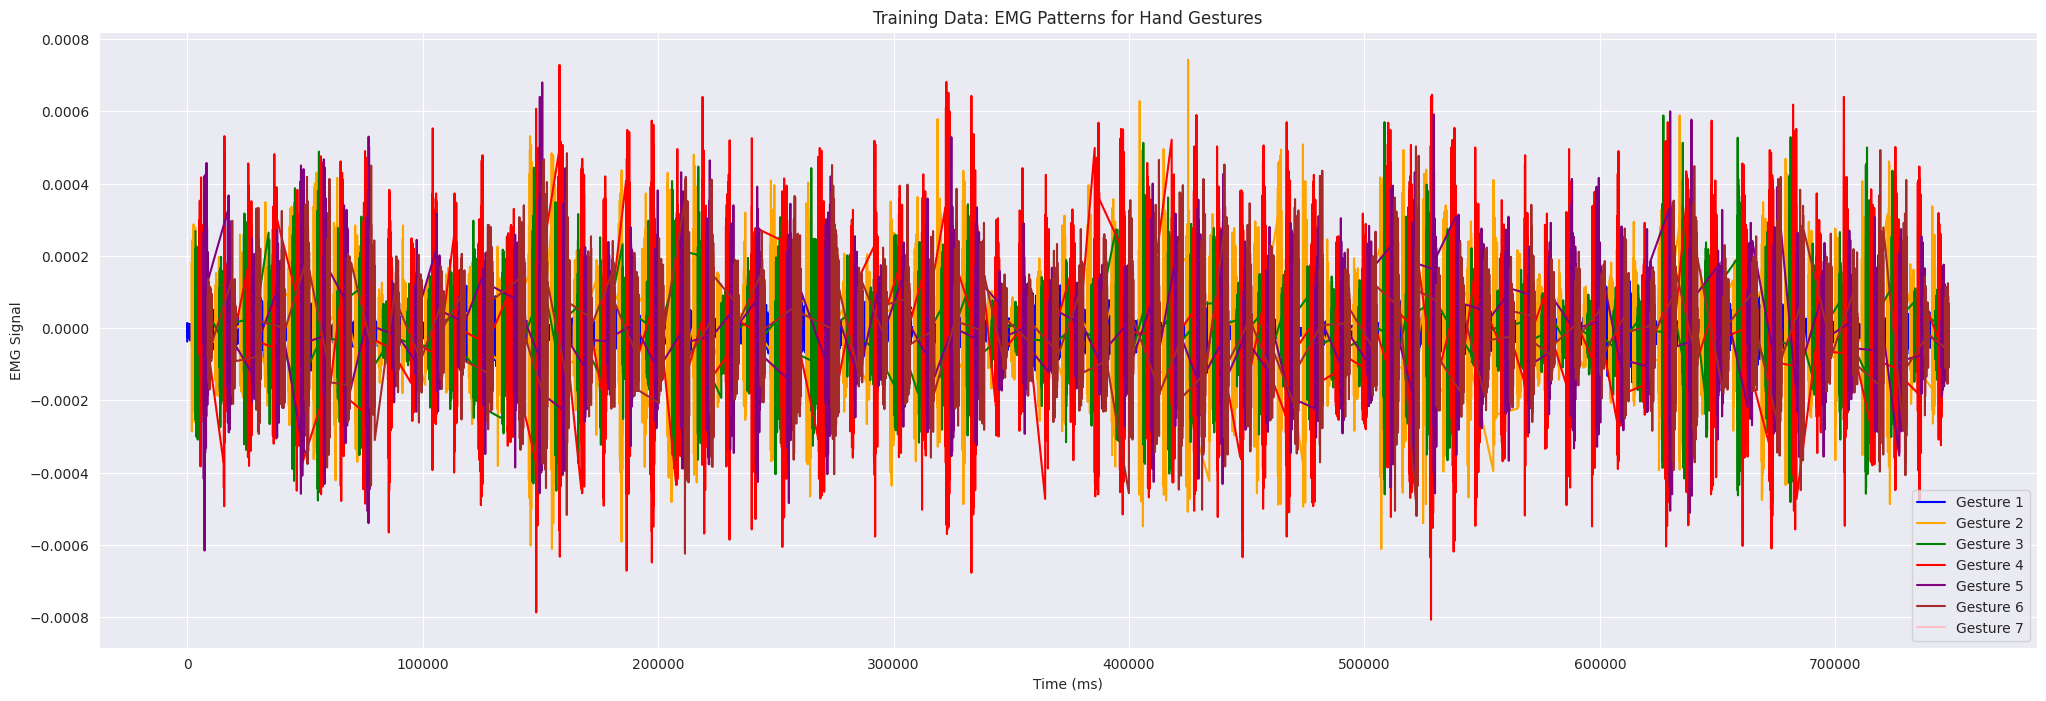

In [21]:
plot_labeled_data(labeled_train, 'Training Data: EMG Patterns for Hand Gestures')

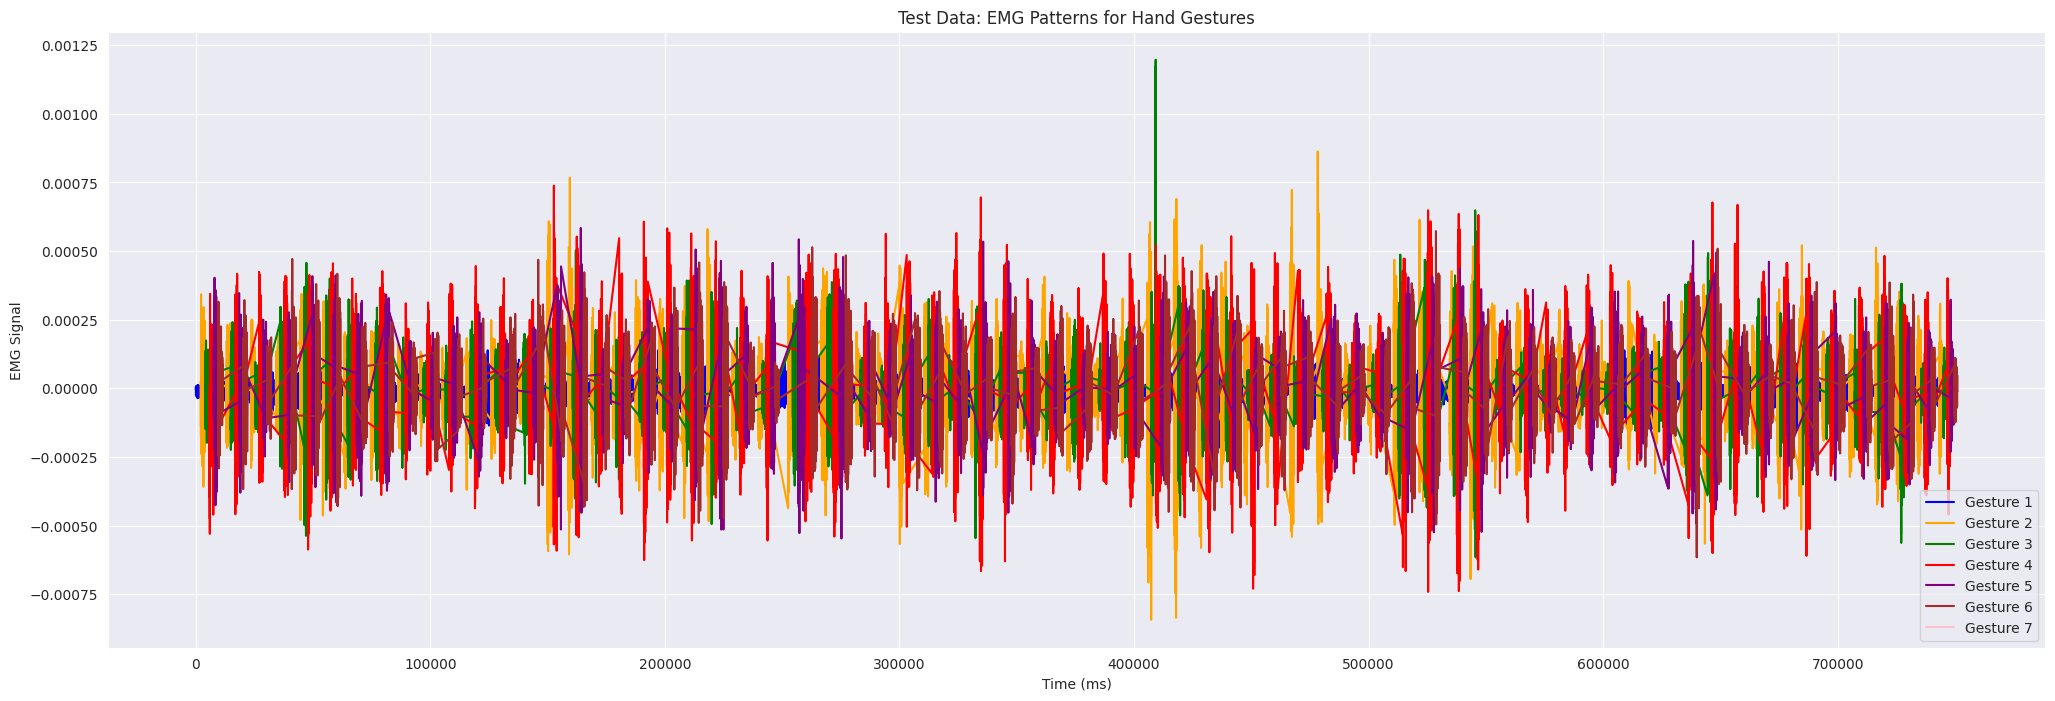

In [22]:
plot_labeled_data(labeled_test, 'Test Data: EMG Patterns for Hand Gestures')

In [23]:
print('Train Classes: ', labeled_train['class'].unique())
print('Test Classes: ', labeled_test['class'].unique())

Train Classes:  [1 2 3 4 5 6]
Test Classes:  [1. 2. 3. 4. 5. 6.]


In [24]:
labeled_test.isna().sum()

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64

### Below we show the correlation matrix comparing the correlation between the 8 channels. We want ti=o understand if the subjects and channels are independent of each other. We have plotted the correlation plots for subject 1, 10,20 and 30. We can see the correlation matrices changing for these subjects, which tells us subjects are independent.

<Axes: >

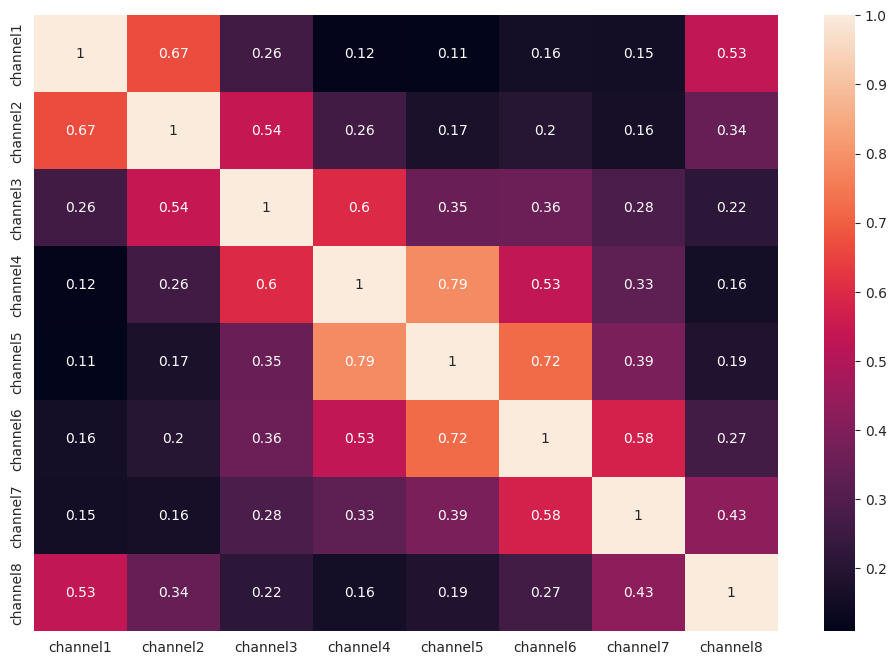

In [25]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(labeled_train[labeled_train.subject_id == 1].iloc[:,1:9].corr(),annot=True)

<Axes: >

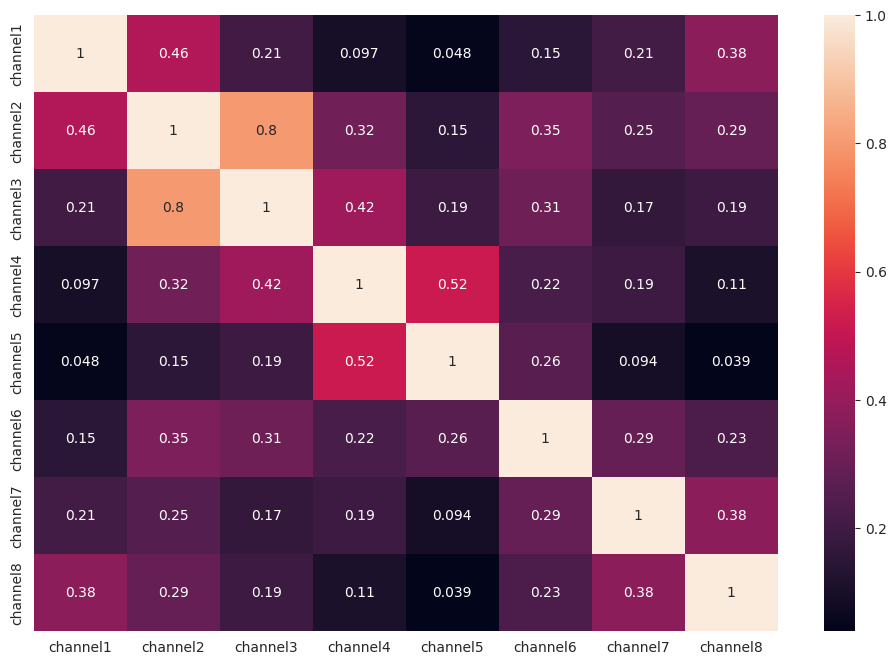

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(labeled_train[labeled_train.subject_id == 10].iloc[:,1:9].corr(),annot=True)

<Axes: >

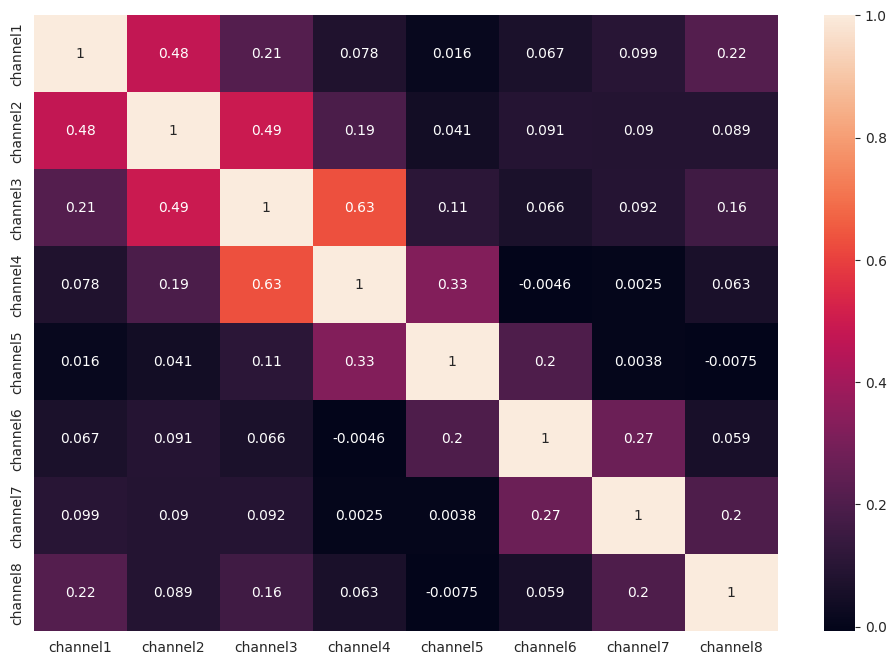

In [27]:
plt.figure(figsize=(12,8))
sns.heatmap(labeled_train[labeled_train.subject_id == 20].iloc[:,1:9].corr(),annot=True)

<Axes: >

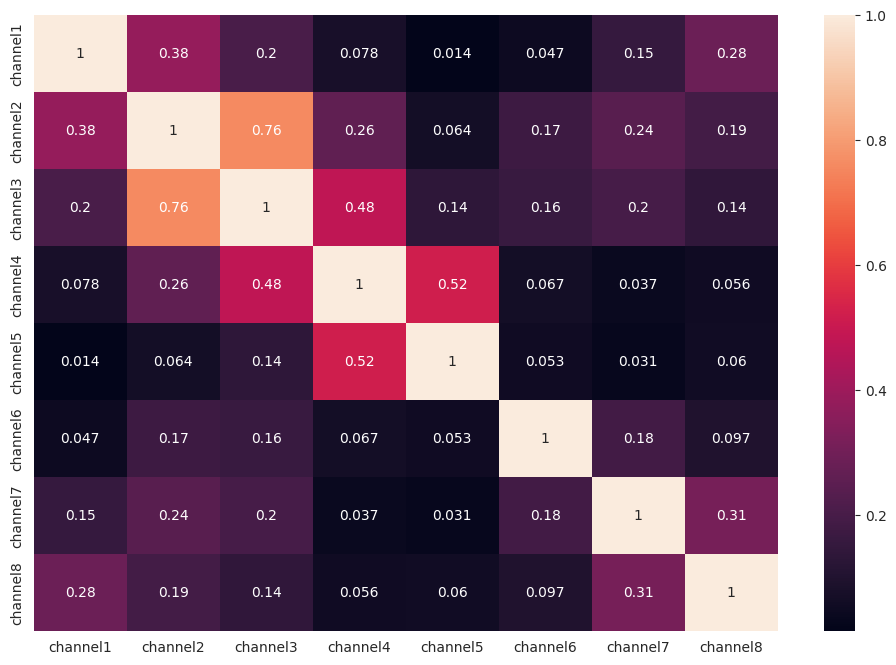

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(labeled_train[labeled_train.subject_id == 30].iloc[:,1:9].corr(),annot=True)

### Here we have plotted the correlation for whole dataset (for all subjects) whihc tells us there is not much correlation between channels. Hence we assume channels are independent.

<Axes: >

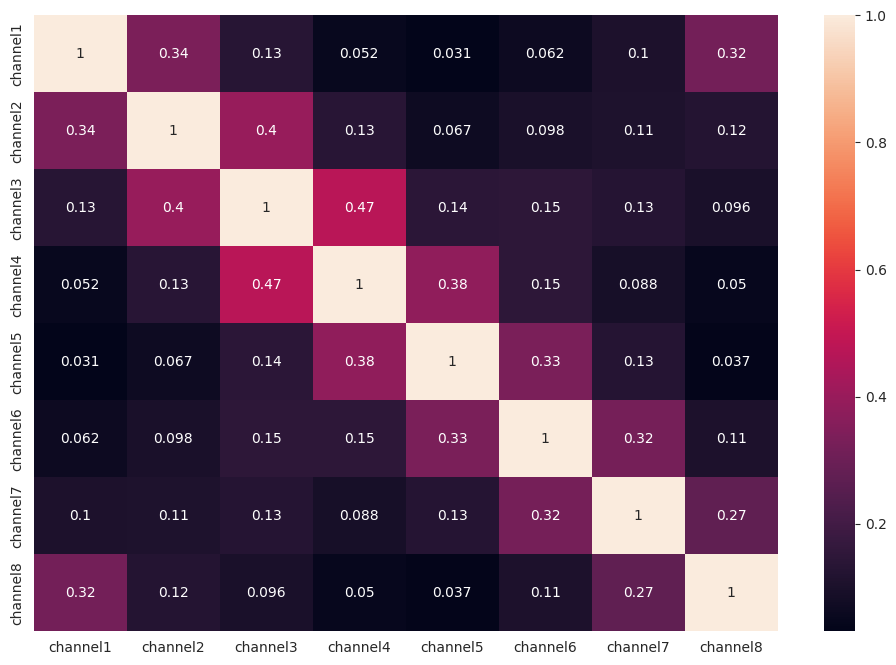

In [29]:
plt.figure(figsize=(12,8))
sns.heatmap(labeled_train.iloc[:,1:9].corr(),annot=True)

## Feature Extraction

### TIME DOMAIN

Here we will extract catch22 features from the time series. Catch 22 is a set of 22 features best suitable for time series problems. These 22 features are a subset of a MATLAB hctsa toolbox of features which contains 7658 features for time series. According to the paper 'The Canonical Interval Forest (CIF) Classifier forTime Series Classification' by Matthew Middlehurst, James Large and Anthony Bagnall, in the first step 766 out of 7658 features were removed because they were related to mean and variance and all the datasets in UCR repository were normalised. Hence we relaised that we catch 22 can only be done on noramlized data. 

In [30]:
def normalize(X):
  trainMean = np.mean(X,axis=0)
  trainStd = np.std(X,axis=0)
  return (X - trainMean)/trainStd,trainMean,trainStd

In [31]:
def normalizeTest(X,trainMean,trainStd):
  return (X - trainMean)/trainStd

In [32]:
def catch22_features(df, signal_interval=1024):
    catch22_list = []
    # iterate over each subject in the data
    for subject_id in df['subject_id'].unique():
        # iterate over each channel in the data
        for channel in range(1, 9):
            sub_df = df.loc[df['subject_id']==subject_id, f'channel{channel}']
            # split the data into intervals of length 1024
            intervals = np.array_split(sub_df, len(sub_df)//signal_interval)
            y_segments = np.array_split(df.loc[df['subject_id']==subject_id, 'class'], len(sub_df)//signal_interval)
            # for each signal interval
            for int_idx, interval in enumerate(intervals):
                # apply catch22 on the interval and compute the mean of all the features
                features_interval = pycatch22.catch22_all(interval)
                # compute more statistical features for the data of each channel
                interval_stats = {}
                class_mode = statistics.mode(y_segments[int_idx])
                interval_stats['class_mode'] = class_mode
                interval_stats['subject_id'] = subject_id
                interval_stats['channel'] = channel
                interval_stats['interval'] = int_idx    
                interval_stats['skew'] = stats.skew(interval)    
                interval_stats['kurtosis'] = stats.kurtosis(interval)    
                # map feature names to feature values for each signal interval
                features_mean = {feature_name: feature_value for feature_name, feature_value in zip(features_interval['names'], features_interval['values'])}
                interval_dict = {**interval_stats, **features_mean}
                catch22_list.append(interval_dict)

    catch22_df = pd.DataFrame(catch22_list)
    return catch22_df

In [33]:
labeled_train_normalized = labeled_train.copy()
labeled_test_normalized = labeled_test.copy()

In [34]:
labeled_train_normalized.iloc[:,1:9],trainingMean,trainingStd = normalize(labeled_train_normalized.iloc[:,1:9])
labeled_test_normalized.iloc[:,1:9] = normalizeTest(labeled_test_normalized.iloc[:,1:9],trainingMean,trainingStd)

In [35]:
catch22_train = catch22_features(labeled_train_normalized)
catch22_train_512 = catch22_features(labeled_train_normalized,512)
catch22_train_256 = catch22_features(labeled_train_normalized,256)
catch22_train = pd.concat((catch22_train,catch22_train_512,catch22_train_256),axis=0)

In [36]:
catch22_test = catch22_features(labeled_test_normalized)
catch22_test_512 = catch22_features(labeled_test_normalized,512)
catch22_test_256 = catch22_features(labeled_test_normalized,256)
catch22_test = pd.concat((catch22_test,catch22_test_512,catch22_test_256),axis=0)

In [37]:
X_train = catch22_train.drop('class_mode', axis=1)
y_train = catch22_train['class_mode']

X_test = catch22_test.drop('class_mode', axis=1)
y_test = catch22_test['class_mode']

In [38]:
X_train.head()

,subject_id,channel,interval,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,0,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,1,1,2,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,1,1,3,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,1,1,4,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081


## CO_HistogramAMI_even_2_5,MD_hrv_classic_pnn40,SB_Motifthree_quntile_hh,SB_transitionMatrix_3ac_sumdiagcov


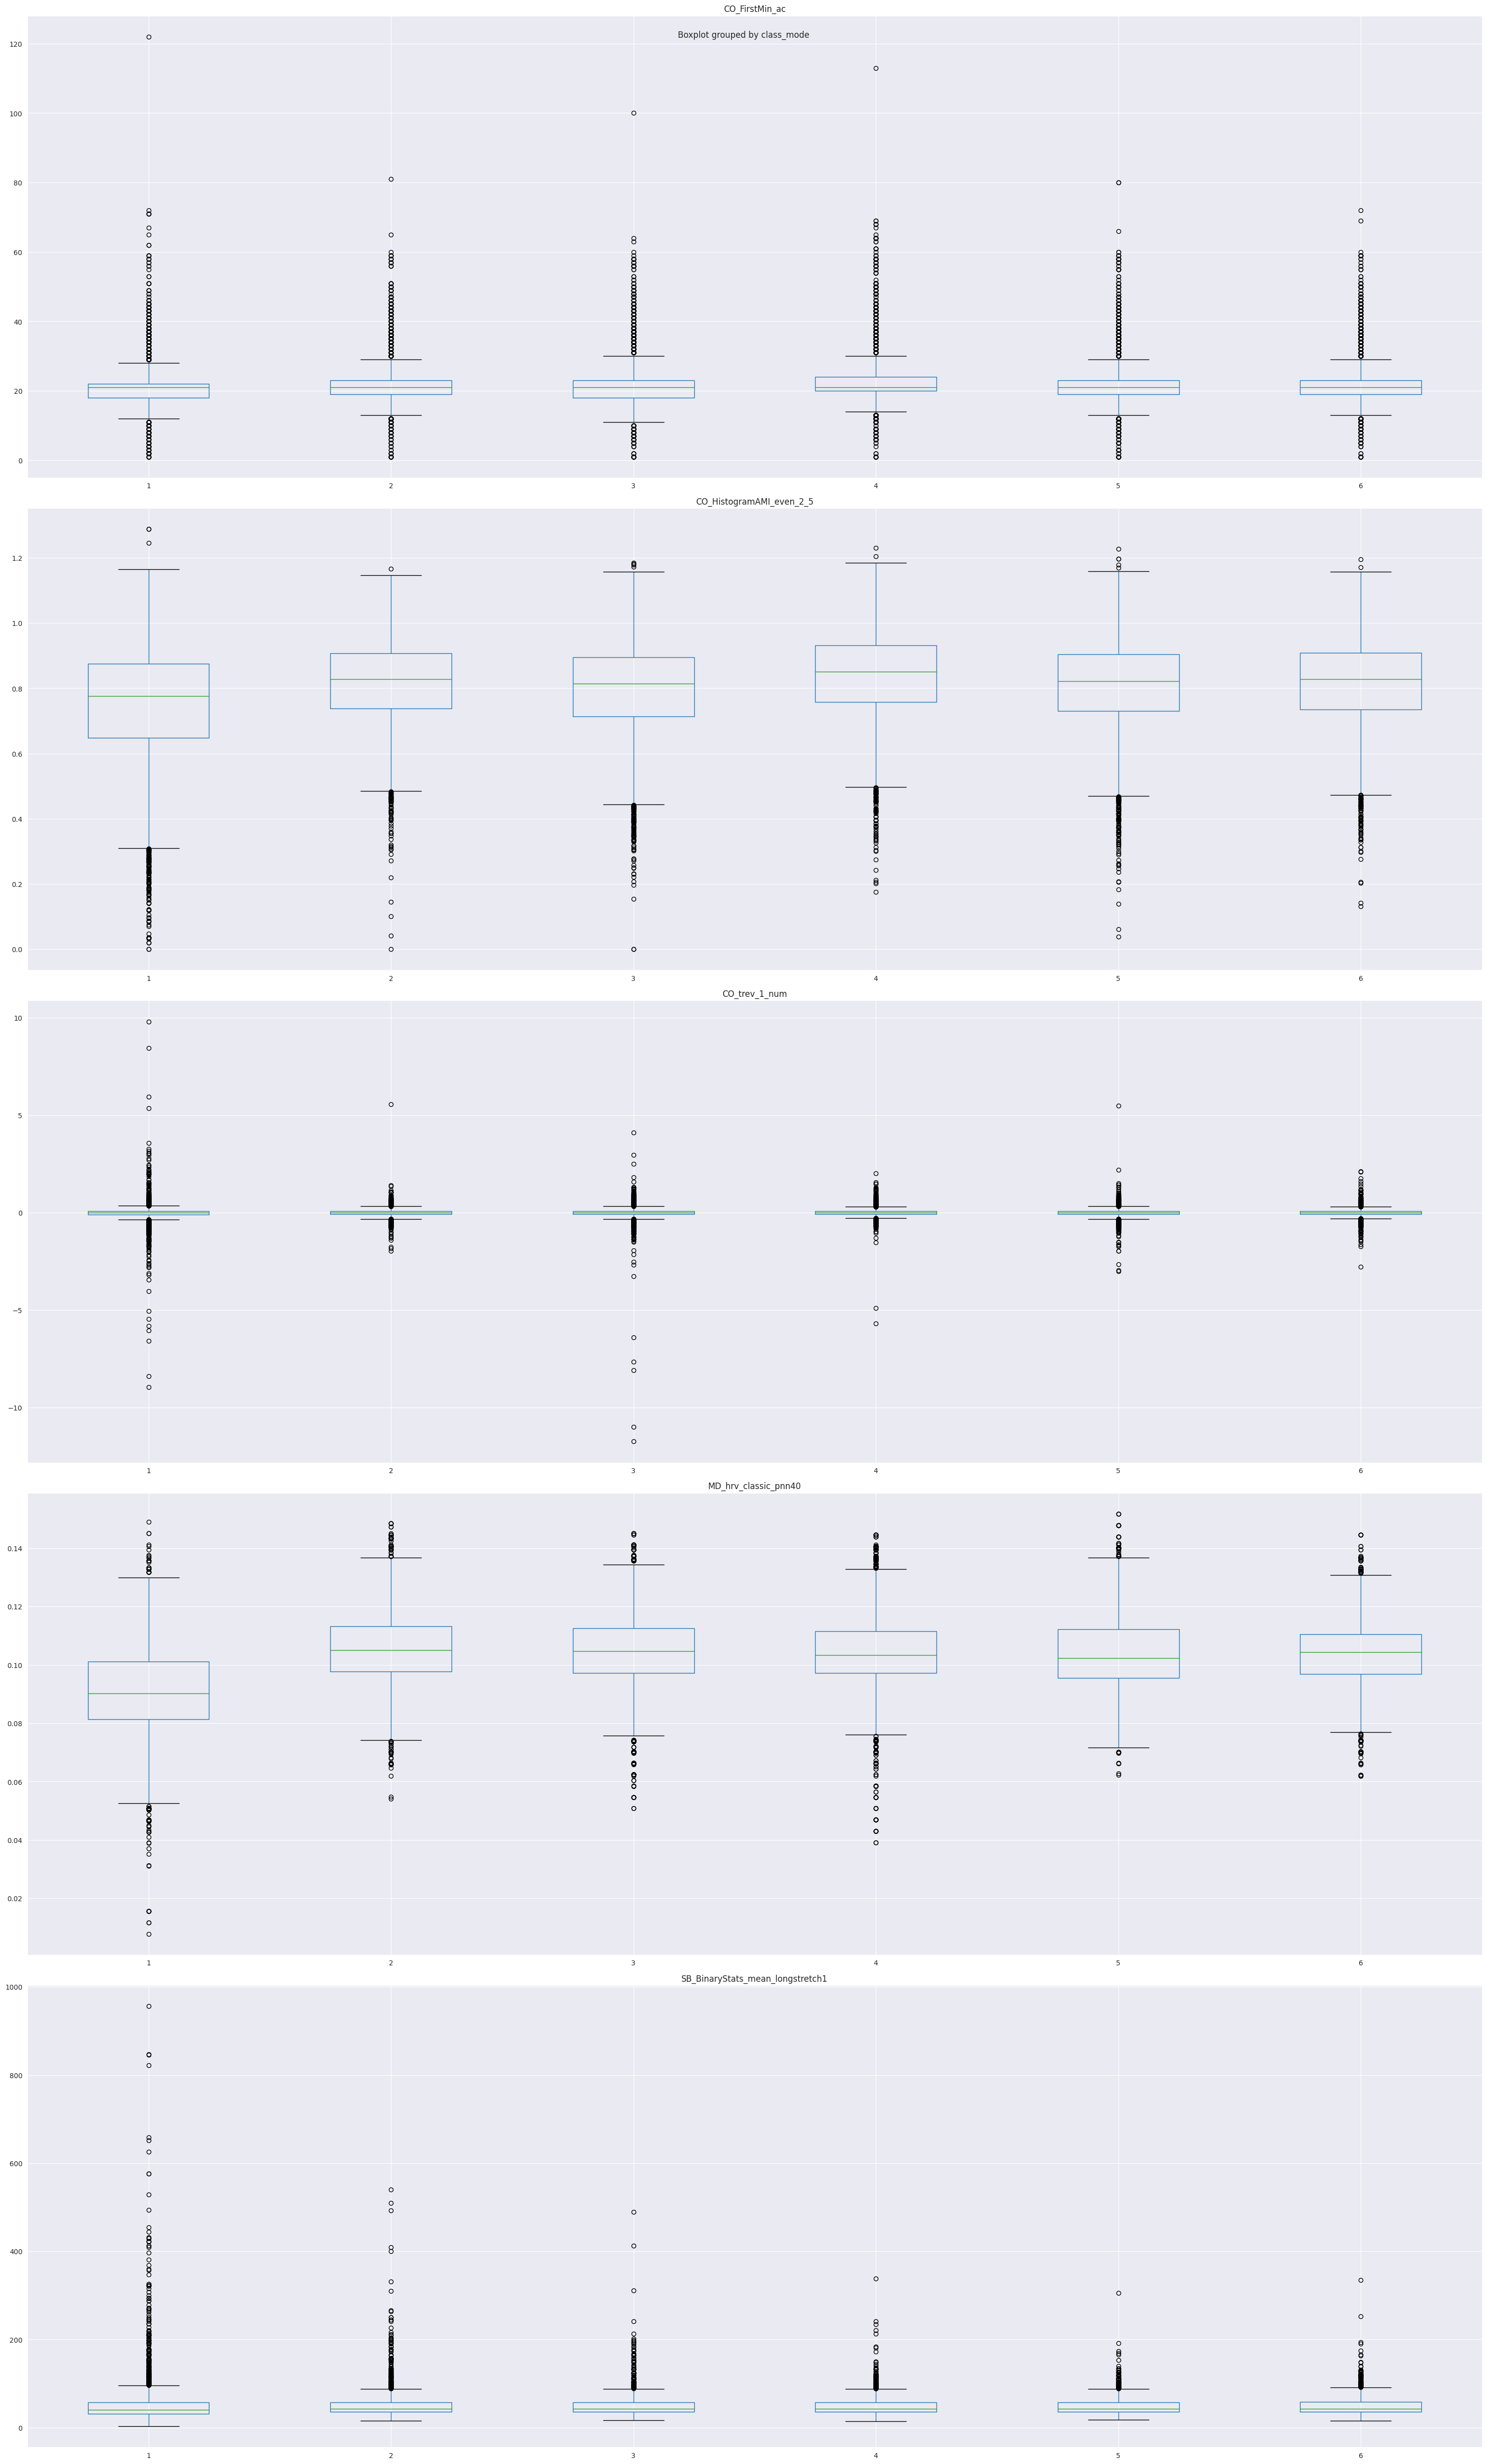

In [39]:
import matplotlib.pyplot as plt
c22_col = X_train.columns[8:13]


fig, axes = plt.subplots(nrows=len(c22_col), figsize=(30, 50))
for i, col in enumerate(c22_col):
  catch22_train.boxplot(column=[col], by = 'class_mode',ax=axes[i])
  axes[i].set_title(col)
  axes[i].set_xlabel("")
  #plt.suptitle(col, y=0.92, fontsize=16)
  plt.tight_layout()
plt.show()

In [40]:
catch22_train.columns

Index(['class_mode', 'subject_id', 'channel', 'interval', 'skew', 'kurtosis',
       'DN_HistogramMode_5', 'DN_HistogramMode_10', 'CO_f1ecac',
       'CO_FirstMin_ac', 'CO_HistogramAMI_even_2_5', 'CO_trev_1_num',
       'MD_hrv_classic_pnn40', 'SB_BinaryStats_mean_longstretch1',
       'SB_TransitionMatrix_3ac_sumdiagcov', 'PD_PeriodicityWang_th0_01',
       'CO_Embed2_Dist_tau_d_expfit_meandiff',
       'IN_AutoMutualInfoStats_40_gaussian_fmmi',
       'FC_LocalSimple_mean1_tauresrat', 'DN_OutlierInclude_p_001_mdrmd',
       'DN_OutlierInclude_n_001_mdrmd', 'SP_Summaries_welch_rect_area_5_1',
       'SB_BinaryStats_diff_longstretch0', 'SB_MotifThree_quantile_hh',
       'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
       'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
       'SP_Summaries_welch_rect_centroid', 'FC_LocalSimple_mean3_stderr'],
      dtype='object')

In [41]:
from sklearn.model_selection import train_test_split
subset_22 = ['CO_HistogramAMI_even_2_5','MD_hrv_classic_pnn40','SB_MotifThree_quantile_hh','SB_TransitionMatrix_3ac_sumdiagcov']
#subset_22 = ['MD_hrv_classic_pnn40']
X_train_subset = X_train.loc[:,subset_22]
X_validation,X_test,y_validation,y_test = train_test_split(X_test,y_test,test_size=0.5,shuffle=False)
X_validation_subset = X_validation.loc[:,subset_22]
X_test_subset = X_test.loc[:,subset_22]

In [42]:
X_train.head()

,subject_id,channel,interval,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,0,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,1,1,2,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,1,1,3,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,1,1,4,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081


## MODELS FOR TIME DOMAIN CATCH 22

### Weights initialized as 1/70, to avioid log(0)

In [43]:
class LogisticRegression:
  
  def __init__(self,learningRate,maxIteration,tolerance,removeIndex=[],doNormalization=False,doStandardization=False,ridgeRegression=False,regualrizationParameter=1):
    self.learningRate = learningRate
    self.maxIteration = maxIteration
    self.tolerance = tolerance
    self.removeIndex = removeIndex
    self.doNormalization = doNormalization
    self.doStandardization = doStandardization
    self.ridgeRegression = ridgeRegression
    self.regualrizationParameter = regualrizationParameter

  def normalize(self,X):
    self.trainingMean = np.mean(X,axis=0)
    self.trainingStd = np.std(X,axis=0)
    return (X - self.trainingMean)/self.trainingStd

  def normalizeTest(self,X):
    return (X - self.trainingMean)/self.trainingStd

  def standardize(self,X):
    self.trainMin = np.min(X,axis=0)
    self.trainMax = np.max(X,axis=0)
    self.trainRange = self.trainMax - self.trainMin
    return (X - self.trainMin)/(self.trainRange)

  def standardizeTest(self,X):
    return (X - self.trainMin)/(self.trainRange)

  def add_X0(self,X):
    return np.column_stack([np.ones(X.shape[0],dtype=np.float16),X])

  def sigmoid(self,z):
    sig = 1 / (1 + np.exp(-z))
    return sig

  def costFunction(self,X,y):
    sig = self.sigmoid(X.dot(self.w))
    # print(sig)
    loss = y * np.log(sig) + (1-y)*np.log(1-sig)
    cost = - np.sum(loss)
    return cost

  def gradient(self,X_train,y_train):
    sig = self.sigmoid(X_train.dot(self.w))
    # print(sig)
    grad = (sig-y_train).dot(X_train)
    return grad

  def gradientWithRidge(self,X_train,y_train):
    sig = self.sigmoid(X_train.dot(self.w))
    # print(sig)
    grad = (sig-y_train).dot(X_train) + self.regualrizationParameter * self.w
    return grad

  def gradientDescent(self,X_train,y_train):
    losses = []
    prevLoss = float('inf')
    for i in tqdm(range(self.maxIteration),colour='red'):
      #X_sample,_,y_sample,__ = train_test_split(X_train,y_train,shuffle=True,train_size = 0.15)
      if self.ridgeRegression:
        self.w = self.w - self.learningRate * self.gradientWithRidge(X_train,y_train)
      else:
        self.w = self.w - self.learningRate * self.gradient(X_train,y_train)
      # break
      currentLoss = self.costFunction(X_train,y_train)
      diff_loss = np.abs(prevLoss - currentLoss)
      losses.append(currentLoss)

      if diff_loss < self.tolerance:
        print('Change in error below tolerance')
        break

      prevLoss = currentLoss

    #self.plot()

  def predict(self,X):
    if self.doNormalization:
      X = self.normalizeTest(X)
    if self.doStandardization:
      X = self.standardizeTest(X)
    X = self.add_X0(X)
    sig = self.sigmoid(X.dot(self.w))
    return sig

  def fit(self,X_train,y_train):
    if self.doNormalization:
      X_train = self.normalize(X_train)
    if self.doStandardization:
      X_train = self.standardize(X_train)
    X_train = self.add_X0(X_train)
    self.w = np.ones(X_train.shape[1],dtype=np.float16)
    self.w = self.w/70
    # print(X_train.dot(self.w))
    print('Solving using gradient Descent')
    self.gradientDescent(X_train,y_train)

      

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
lr = LogisticRegression(tolerance=0.001,learningRate=0.1e-04,maxIteration=10000)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else 0)
  lr.fit(X_train_subset.values,y_train_category.values)
  probability_df = pd.DataFrame(lr.predict(X_test_subset.values))
  # print(probability_df)
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x) + 1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)

print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
lr = LogisticRegression(tolerance=0.001,learningRate=0.1e-04,maxIteration=10000)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else 0)
  lr.fit(X_train.values,y_train_category.values)
  probability_df = pd.DataFrame(lr.predict(X_test.values))
  # print(probability_df)
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x) + 1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
lr = LogisticRegression(tolerance=0.001,learningRate=0.1e-04,maxIteration=10000)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else 0)
  lr.fit(X_train_subset.values,y_train_category.values)
  probability_df = pd.DataFrame(lr.predict(X_test_subset.values))
  # print(probability_df)
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x) + 1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)

print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

Solving using gradient Descent


100%|██████████| 10000/10000 [00:48<00:00, 204.97it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:48<00:00, 204.75it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:49<00:00, 202.72it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:50<00:00, 198.01it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:49<00:00, 203.62it/s]


Solving using gradient Descent


 15%|█▌        | 1516/10000 [00:06<00:34, 247.76it/s]


Change in error below tolerance
Confusion Matrix
[[1683    0    0  281    0 1560]
 [ 417    0    0  787    0 2101]
 [ 474    4    0  534    0 2347]
 [ 355    9    0  901    0 2091]
 [ 526    0    0  603    0 2267]
 [ 513   10    0  802    0 2055]]
Accuracy
0.22829724409448818


In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
lr = LogisticRegression(tolerance=0.001,learningRate=0.1e-04,maxIteration=10000,ridgeRegression=True,regualrizationParameter=1)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else 0)
  lr.fit(X_train_subset.values,y_train_category.values)
  probability_df = pd.DataFrame(lr.predict(X_test_subset.values))
  # print(probability_df)
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x) + 1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)

print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

Solving using gradient Descent


100%|██████████| 10000/10000 [00:48<00:00, 204.11it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:57<00:00, 174.77it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [01:04<00:00, 155.91it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:48<00:00, 207.02it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:49<00:00, 202.93it/s]


Solving using gradient Descent


 10%|▉         | 999/10000 [00:03<00:35, 251.62it/s]


Change in error below tolerance
Confusion Matrix
[[1664    0    0  281    0 1579]
 [ 411    0    0  787    0 2107]
 [ 466    4    0  534    0 2355]
 [ 355    3    0  907    0 2091]
 [ 518    0    0  603    0 2275]
 [ 509    7    0  805    0 2059]]
Accuracy
0.22785433070866143


In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
lr = LogisticRegression(tolerance=0.001,learningRate=0.1e-04,maxIteration=10000,ridgeRegression=True,regualrizationParameter=10)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else 0)
  lr.fit(X_train_subset.values,y_train_category.values)
  probability_df = pd.DataFrame(lr.predict(X_test_subset.values))
  # print(probability_df)
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x) + 1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)

print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

Solving using gradient Descent


100%|██████████| 10000/10000 [00:54<00:00, 184.60it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [00:49<00:00, 202.67it/s]


Solving using gradient Descent


 78%|███████▊  | 7767/10000 [00:38<00:11, 200.00it/s]


Change in error below tolerance
Solving using gradient Descent


 37%|███▋      | 3740/10000 [00:18<00:31, 201.85it/s]


Change in error below tolerance
Solving using gradient Descent


 36%|███▌      | 3550/10000 [00:16<00:30, 209.82it/s]


Change in error below tolerance
Solving using gradient Descent


  2%|▏         | 204/10000 [00:00<00:40, 243.18it/s]


Change in error below tolerance
Confusion Matrix
[[1322    0    0    3    0 2199]
 [ 213    0    0    3    0 3089]
 [ 272    4    0   10    0 3073]
 [ 185    3    0   23    0 3145]
 [ 319    0    0   19    0 3058]
 [ 280    7    0   12    0 3081]]
Accuracy
0.21781496062992126


In [73]:
from scipy.spatial.distance import cdist
from scipy.optimize import minimize,Bounds
from dataclasses import dataclass
@dataclass
class SoftMarginSVM:
  C : float
  rbf : bool

  def dualSVM(self, gramXy, alphas):
    return np.sum(alphas) - 0.5 * alphas.dot(alphas.dot(gramXy))

  def jacobian_dualSVM(self,gramXy,alphas):
    return np.ones(len(alphas)) - alphas.dot(gramXy)

  def fit(self,X,y):
    N,n_features = X.shape
    y_ = np.where(y<=0,-1,1)
    self.alphas = np.ones(N)
    bounds = Bounds(np.zeros(N),np.full(N,self.C))
    constraints = ({'type':'eq','fun':lambda a : -np.dot(a, y_),'jac':lambda a:-y_})

    Xy = X * y_[:,np.newaxis]
    if self.rbf:
      gramXY = np.exp(-cdist(Xy,Xy)/2)
    else:
      gramXy = Xy.dot(Xy.T)

    slsqp = minimize(fun = lambda a : -self.dualSVM(gramXy,a),
                     x0=self.alphas,
                     jac = lambda a : -self.jacobian_dualSVM(gramXy,a),
                     bounds=bounds,
                     constraints=constraints,
                     method='SLSQP')
    
    self.alphas = slsqp.x
    self.w = np.sum((self.alphas[:,np.newaxis] * Xy),axis=0)
    epsilon = 1e-4
    self.supportVectors = X[ self.alphas > epsilon]
    self.supportLabels = y[ self.alphas > epsilon]

    b = []
    for i in range(len(self.supportLabels)):
      b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
      b.append(b_i)
        
    self.intercept = sum(b)/len(b)

  def sigmoid(self,z):
    sig = 1 / (1 + np.exp(-z))
    return sig

  def predict(self,X):
    sig = self.sigmoid(X.dot(self.w)+self.intercept)
    return sig

In [70]:
X_train.shape[0] * 0.005

202.32

In [75]:
from sklearn.model_selection import train_test_split
svm = SoftMarginSVM(C=1,rbf=False)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else -1)
  X_Sample,_,y_Sample,_ = train_test_split(X_train,y_train_category.values,train_size=0.005,shuffle=True)
  svm.fit(X_Sample.values,y_Sample)
  probability_df = pd.DataFrame(svm.predict(X_test.values))
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x)+1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

Confusion Matrix
[[2062  868    0  587    0    7]
 [1467 1189    0  645    0    4]
 [1333 1417    0  603    0    6]
 [1118 1634    0  592    0   12]
 [ 851 1883    0  641    0   21]
 [ 512 2214    0  636    0   18]]
Accuracy
0.19000984251968503


In [79]:
from sklearn.model_selection import train_test_split
svm = SoftMarginSVM(C=1,rbf=False)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else -1)
  X_Sample,_,y_Sample,_ = train_test_split(X_train_subset,y_train_category.values,train_size=0.005,shuffle=True)
  svm.fit(X_Sample.values,y_Sample)
  probability_df = pd.DataFrame(svm.predict(X_test_subset.values))
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x)+1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

Confusion Matrix
[[3524    0    0    0    0    0]
 [3305    0    0    0    0    0]
 [3359    0    0    0    0    0]
 [3356    0    0    0    0    0]
 [3396    0    0    0    0    0]
 [3380    0    0    0    0    0]]
Accuracy
0.1734251968503937


In [82]:
from sklearn.model_selection import train_test_split
svm = SoftMarginSVM(C=10,rbf=False)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else -1)
  X_Sample,_,y_Sample,_ = train_test_split(X_train_subset,y_train_category.values,train_size=0.025,shuffle=True)
  svm.fit(X_Sample.values,y_Sample)
  probability_df = pd.DataFrame(svm.predict(X_test_subset.values))
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x)+1,axis=1)
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

Confusion Matrix
[[3524    0    0    0    0    0]
 [3305    0    0    0    0    0]
 [3359    0    0    0    0    0]
 [3356    0    0    0    0    0]
 [3396    0    0    0    0    0]
 [3380    0    0    0    0    0]]
Accuracy
0.1734251968503937


In [ ]:
# svm = SoftMarginSVM(C=10,rbf=True)
# unique_y = y_train.unique()
# category_probabilities = pd.DataFrame()
# for category in unique_y:
#   y_train_category = y_train.map(lambda x : 1 if x == category else 0)
#   lr.fit(X_train_subset.values,y_train_category.values)
#   probability_df = pd.DataFrame(lr.predict(X_test_subset.values))
#   # print(probability_df)
#   category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
# predictions = category_probabilities.apply(lambda x : np.argmax(x) + 1,axis=1)
# c=confusion_matrix(y_test,predictions)
# a=accuracy_score(y_test,predictions)
# print('Confusion Matrix')
# print(c)
# print('Accuracy')
# print(a)

### Frequency Domain

In [ ]:
CHANNELS = ["channel" + str(x) for x in range(1,9)]

In [ ]:
def generate_segments(data_length, segment_length, span):
    # Calculate the number of segments based on the desired length of each segment
    num_segments = int(data_length / segment_length)

    # Create a list of tuples representing each segment needed for processing
    segments = []
    for i in range(num_segments):
        # Calculate the center of the segment and its range start and end positions
        segment_center = i * segment_length + int(segment_length / 2)
        segment_start = max(0, int(segment_center - span / 2))
        segment_end = min(segment_center + span / 2, data_length - 1)
        segments.append((int(segment_start), int(segment_end)))

    # Return the list of segment tuples
    return segments

def refactor_amplitude(channel_data, segment_ranges):
    # Initialize an empty list to hold the refactored amplitude values
    refactored_data = []

    # Iterate through each segment range and calculate the average peak amplitude within that range
    for segment_range in segment_ranges:
        segment_data = channel_data[segment_range[0]:segment_range[1]]

        # Find the peak amplitudes within the segment
        peak_indices = find_peaks(segment_data)[0]
        peaks = [segment_data[ind] for ind in peak_indices]

        # Calculate the average peak amplitude within the segment
        if len(peaks) > 0:
            avg_peak_amplitude = sum(peaks) / len(peaks)
            refactored_data.append(avg_peak_amplitude)
        else:
            # If there are no peaks within the segment, calculate the average amplitude instead
            avg_amplitude = sum(segment_data) / len(segment_data)
            refactored_data.append(avg_amplitude)

    # Return the list of refactored amplitude values
    return refactored_data


def refactor_labels(class_data, segment_ranges):
    # Initialize an empty list to hold the refactored label values
    refactored_class = []

    # Iterate through each segment range and calculate the mode label within that range
    for segment_range in segment_ranges:
        segment_data = class_data[segment_range[0]:segment_range[1]]

        # Find the mode label within the segment
        unique_labels, label_counts = np.unique(segment_data, return_counts=True)
        mode_label = max(dict(zip(unique_labels, label_counts)).items(), key=operator.itemgetter(1))[0]

        refactored_class.append(mode_label)

    # Return the list of refactored label values
    return refactored_class


In [ ]:
def refactor_catch22(channel,channel_data, segment_ranges):
    # Initialize an empty list to hold the refactored Catch22 feature values
    refactored_data = []
    # Iterate through each segment range and calculate the Catch22 features within that range
    for segment_range in segment_ranges:
        segment_data = channel_data[segment_range[0]:segment_range[1]]

        # Calculate the Catch22 features within the segment
        segment_features = pycatch22.catch22_all(segment_data)
        
        refactored_data.append(dict(zip([name + channel for name in segment_features['names']], segment_features['values'])))

    # Return the list of refactored Catch22 feature values
    return pd.DataFrame(refactored_data)


In [ ]:
def compile_data(df, df_normalized,segment_num = 320, span=1000):
    catch22_list = []
    all_subject_data = []
    # iterate over each subject in the data
    for subject_id in df['subject_id'].unique():
        print('Processing Subject: ', subject_id)
        refactored_data = pd.DataFrame(index=[], columns=[])
        catch22_data = pd.DataFrame(index=[], columns=[])
        # iterate over each channel in the data
        for channel in tqdm(CHANNELS,colour='blue'):
            sub_df = df.loc[df['subject_id']==subject_id, channel].values
            sub_df_normalized = df_normalized.loc[df_normalized['subject_id']==subject_id, channel].values
            segment_len = len(sub_df) / segment_num
            ranges = generate_segments(len(sub_df), segment_len, span)
            # apply amplitude refactoring
            refactored_channel_data = refactor_amplitude(sub_df, ranges)
            refactored_data[channel] = refactored_channel_data
            # apply catch22 feature engineering to each subject-channel pair 
            catch22_features = refactor_catch22(channel,sub_df_normalized, ranges)
            refactored_data = pd.concat((refactored_data,catch22_features),axis=1)
            #[for featurea in catch22_features]
            #catch22_data[channel] = catch22_features.tolist()
        refactored_data['subject_id'] = subject_id
        # catch22_data['subject_id'] = subject_id
        sub_df2 = df.loc[df['subject_id']==subject_id, ['class', 'time']].values
        class_refactor = refactor_labels(sub_df2[:,0], ranges)
        time_refactor = refactor_labels(sub_df2[:,1], ranges)
        refactored_data["time"] = time_refactor
        refactored_data["class"] = class_refactor

        seg_data = (refactored_data['time'] - 1) // 320 + 1
        refactored_data['segment'] = seg_data.values
        # catch22_data['segment'] = seg_data.values
        #Add a new column to identify the segment number
        refactored_data['segment'] = (refactored_data['time'] - 1) // (320 + 1)
        all_subject_data.append(refactored_data)
        # catch22_list.append(catch22_data)
    # Concatenate all the dataframes into a single dataframe
    concatenated_data = pd.concat(all_subject_data)
    # catch22_list = pd.concat(catch22_list)
    # normalise the data
    #concatenated_data[CHANNELS] = (concatenated_data[CHANNELS] - np.mean(concatenated_data[CHANNELS]], axis=0)) / np.std(concatenated_data[CHANNELS], axis=0)
    print('\n--- Completed Processing ---')
    return concatenated_data #, catch22_list

In [ ]:
import threading

def compile_data_threaded(df, segment_num=320, span=1000):
    results = []
    threads = []

    def process_subject(subject_id):
        print('Processing Subject: ', subject_id)
        subject_data = df.loc[df['subject_id'] == subject_id].copy()
        subject_result = compile_data(subject_data, segment_num, span)
        results.append(subject_result)

    # iterate over each subject in the data
    for subject_id in df['subject_id'].unique():
        thread = threading.Thread(target=process_subject, args=(subject_id,))
        threads.append(thread)
        thread.start()

    # Wait for all threads to finish
    for thread in threads:
        thread.join()

    # Combine results from all subjects into a single dataframe
    concatenated_data = pd.concat([r for r in results])
    # catch22_list = pd.concat([r[1] for r in results])

    # normalise the data
    # concatenated_data.iloc[:,0:8] = (concatenated_data.iloc[:,0:8] - np.mean(concatenated_data.iloc[:,0:8], axis=0)) / np.std(concatenated_data.iloc[:,0:8], axis=0)

    return concatenated_data #, catch22_list


In [ ]:
labeled_train.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
1,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
2,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
3,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
4,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1


 88%|████████▊ | 7/8 [09:57<01:29, 89.64s/it]




 88%|████████▊ | 7/8 [09:58<01:26, 86.89s/it]














 75%|███████▌  | 6/8 [09:58<03:20, 100.19s/it]

In [ ]:
print('Train Data Processing')
compiled_train = compile_data_threaded(labeled_train, segment_num = 320, span=1000)
print('\nTest Data Processing')
compiled_test = compile_data_threaded(labeled_test, segment_num = 320, span=1000)

Train Data Processing
Processing Subject:  1
Processing Subject:  Processing Subject:  3
2
Processing Subject:  4
Processing Subject: Processing Subject:  4 5
Processing Subject:  6



  0%|          | 0/8 [00:00<?, ?it/s]

Processing Subject:  7
Processing Subject:  2
Processing Subject:  1
Processing Subject:  3



  0%|          | 0/8 [00:00<?, ?it/s]



Processing Subject:  8
Processing Subject:  5
Processing Subject:  6
Processing Subject:  9
Processing Subject:  Processing Subject:  10
Processing Subject:  7
11


  0%|          | 0/8 [00:00<?, ?it/s]





Processing Subject:  8
Processing Subject:  12
Processing Subject:  9
Processing Subject:  11
Processing Subject:  13
Processing Subject:  

  0%|          | 0/8 [00:00<?, ?it/s]

14
Processing Subject:  10
Processing Subject:  15
Processing Subject:  14





  0%|          | 0/8 [00:00<?, ?it/s]

Processing Subject:  Processing Subject:  12
16


Processing Subject: Processing Subject:  13
Processing Subject:  17
 15








  0%|          | 0/8 [00:00<?, ?it/s]

Processing Subject:  16
Processing Subject:  17Processing Subject:  18

Processing Subject:  19


Processing Subject:  20
Processing Subject:  18







  0%|          | 0/8 [00:00<?, ?it/s]

Processing Subject:  21
Processing Subject:  19


Processing Subject:  22
Processing Subject: Processing Subject:  23
 Processing Subject:  20
24
Processing Subject:  25
Processing Subject:  21
Processing Subject:  22
Processing Subject:  26
Processing Subject:  23
Processing Subject:  27
Processing Subject:  24
Processing Subject:  25
Processing Subject:  28









  0%|          | 0/8 [00:00<?, ?it/s]

Processing Subject: Processing Subject:  26
 29
Processing Subject: Processing Subject:  28











  0%|          | 0/8 [00:00<?, ?it/s]

Processing Subject:   27
Processing Subject:  29
30
Processing Subject:  31Processing Subject:  30

Processing Subject:  32
Processing Subject:  33


Processing Subject: Processing Subject:  31
 34


  0%|          | 0/8 [00:00<?, ?it/s]












Processing Subject:  35
Processing Subject:  32
Processing Subject:  36
Processing Subject:  34


  0%|          | 0/8 [00:00<?, ?it/s]

Processing Subject:  36
Processing Subject:  33
Processing Subject:  35














  0%|          | 0/8 [00:00<?, ?it/s]














  0%|          | 0/8 [00:00<?, ?it/s]









  0%|          | 0/8 [00:00<?, ?it/s]







  0%|          | 0/8 [00:00<?, ?it/s]
















  0%|          | 0/8 [00:00<?, ?it/s]















  0%|          | 0/8 [00:00<?, ?it/s]

















  0%|          | 0/8 [00:00<?, ?it/s]


















 ... (more hidden) ...













  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# compiled_train.to_csv('/content/catch_22.csv',index=False)

In [ ]:
compiled_train.head()

,channel1,DN_HistogramMode_5channel1,DN_HistogramMode_10channel1,CO_f1ecacchannel1,CO_FirstMin_acchannel1,CO_HistogramAMI_even_2_5channel1,CO_trev_1_numchannel1,MD_hrv_classic_pnn40channel1,SB_BinaryStats_mean_longstretch1channel1,SB_TransitionMatrix_3ac_sumdiagcovchannel1,PD_PeriodicityWang_th0_01channel1,CO_Embed2_Dist_tau_d_expfit_meandiffchannel1,IN_AutoMutualInfoStats_40_gaussian_fmmichannel1,FC_LocalSimple_mean1_tauresratchannel1,DN_OutlierInclude_p_001_mdrmdchannel1,DN_OutlierInclude_n_001_mdrmdchannel1,SP_Summaries_welch_rect_area_5_1channel1,SB_BinaryStats_diff_longstretch0channel1,SB_MotifThree_quantile_hhchannel1,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel1,SP_Summaries_welch_rect_centroidchannel1,FC_LocalSimple_mean3_stderrchannel1,channel2,DN_HistogramMode_5channel2,DN_HistogramMode_10channel2,CO_f1ecacchannel2,CO_FirstMin_acchannel2,CO_HistogramAMI_even_2_5channel2,CO_trev_1_numchannel2,MD_hrv_classic_pnn40channel2,SB_BinaryStats_mean_longstretch1channel2,SB_TransitionMatrix_3ac_sumdiagcovchannel2,PD_PeriodicityWang_th0_01channel2,CO_Embed2_Dist_tau_d_expfit_meandiffchannel2,IN_AutoMutualInfoStats_40_gaussian_fmmichannel2,FC_LocalSimple_mean1_tauresratchannel2,DN_OutlierInclude_p_001_mdrmdchannel2,DN_OutlierInclude_n_001_mdrmdchannel2,SP_Summaries_welch_rect_area_5_1channel2,SB_BinaryStats_diff_longstretch0channel2,SB_MotifThree_quantile_hhchannel2,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel2,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel2,SP_Summaries_welch_rect_centroidchannel2,FC_LocalSimple_mean3_stderrchannel2,channel3,DN_HistogramMode_5channel3,DN_HistogramMode_10channel3,CO_f1ecacchannel3,...,channel7,DN_HistogramMode_5channel7,DN_HistogramMode_10channel7,CO_f1ecacchannel7,CO_FirstMin_acchannel7,CO_HistogramAMI_even_2_5channel7,CO_trev_1_numchannel7,MD_hrv_classic_pnn40channel7,SB_BinaryStats_mean_longstretch1channel7,SB_TransitionMatrix_3ac_sumdiagcovchannel7,PD_PeriodicityWang_th0_01channel7,CO_Embed2_Dist_tau_d_expfit_meandiffchannel7,IN_AutoMutualInfoStats_40_gaussian_fmmichannel7,FC_LocalSimple_mean1_tauresratchannel7,DN_OutlierInclude_p_001_mdrmdchannel7,DN_OutlierInclude_n_001_mdrmdchannel7,SP_Summaries_welch_rect_area_5_1channel7,SB_BinaryStats_diff_longstretch0channel7,SB_MotifThree_quantile_hhchannel7,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel7,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel7,SP_Summaries_welch_rect_centroidchannel7,FC_LocalSimple_mean3_stderrchannel7,channel8,DN_HistogramMode_5channel8,DN_HistogramMode_10channel8,CO_f1ecacchannel8,CO_FirstMin_acchannel8,CO_HistogramAMI_even_2_5channel8,CO_trev_1_numchannel8,MD_hrv_classic_pnn40channel8,SB_BinaryStats_mean_longstretch1channel8,SB_TransitionMatrix_3ac_sumdiagcovchannel8,PD_PeriodicityWang_th0_01channel8,CO_Embed2_Dist_tau_d_expfit_meandiffchannel8,IN_AutoMutualInfoStats_40_gaussian_fmmichannel8,FC_LocalSimple_mean1_tauresratchannel8,DN_OutlierInclude_p_001_mdrmdchannel8,DN_OutlierInclude_n_001_mdrmdchannel8,SP_Summaries_welch_rect_area_5_1channel8,SB_BinaryStats_diff_longstretch0channel8,SB_MotifThree_quantile_hhchannel8,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel8,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel8,SP_Summaries_welch_rect_centroidchannel8,FC_LocalSimple_mean3_stderrchannel8,subject_id,time,class,segment
0,-1.407941,-2.330449,-1.371077,-0.092291,-0.224187,0.214234,-0.053250,-1.890233,43.0,0.016461,57,0.173290,18.0,0.052632,-0.298677,0.049149,0.893525,3.0,1.155622,0.586957,0.565217,0.116583,0.511460,0.000022,-0.138567,0.201243,8.068215,21,0.640631,-0.226419,0.113636,57.0,0.012550,78,0.093193,14.0,0.062500,-0.060491,-0.160681,0.801716,3.0,1.442968,0.652174,0.543478,0.147262,0.635087,0.000025,0.633969,0.332178,8.813173,...,1.052632e-06,0.037509,0.308084,8.218913,20,0.874684,0.086150,0.092803,39.0,0.012397,69,0.196001,19.0,0.041667,-0.030246,0.665406,0.851347,3.0,1.438047,0.413043,0.456522,0.134990,0.596928,6.250000e-07,-0.067981,-0.292745,8.064802,25

In [ ]:
compiled_test.head()

,channel1,DN_HistogramMode_5channel1,DN_HistogramMode_10channel1,CO_f1ecacchannel1,CO_FirstMin_acchannel1,CO_HistogramAMI_even_2_5channel1,CO_trev_1_numchannel1,MD_hrv_classic_pnn40channel1,SB_BinaryStats_mean_longstretch1channel1,SB_TransitionMatrix_3ac_sumdiagcovchannel1,PD_PeriodicityWang_th0_01channel1,CO_Embed2_Dist_tau_d_expfit_meandiffchannel1,IN_AutoMutualInfoStats_40_gaussian_fmmichannel1,FC_LocalSimple_mean1_tauresratchannel1,DN_OutlierInclude_p_001_mdrmdchannel1,DN_OutlierInclude_n_001_mdrmdchannel1,SP_Summaries_welch_rect_area_5_1channel1,SB_BinaryStats_diff_longstretch0channel1,SB_MotifThree_quantile_hhchannel1,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel1,SP_Summaries_welch_rect_centroidchannel1,FC_LocalSimple_mean3_stderrchannel1,channel2,DN_HistogramMode_5channel2,DN_HistogramMode_10channel2,CO_f1ecacchannel2,CO_FirstMin_acchannel2,CO_HistogramAMI_even_2_5channel2,CO_trev_1_numchannel2,MD_hrv_classic_pnn40channel2,SB_BinaryStats_mean_longstretch1channel2,SB_TransitionMatrix_3ac_sumdiagcovchannel2,PD_PeriodicityWang_th0_01channel2,CO_Embed2_Dist_tau_d_expfit_meandiffchannel2,IN_AutoMutualInfoStats_40_gaussian_fmmichannel2,FC_LocalSimple_mean1_tauresratchannel2,DN_OutlierInclude_p_001_mdrmdchannel2,DN_OutlierInclude_n_001_mdrmdchannel2,SP_Summaries_welch_rect_area_5_1channel2,SB_BinaryStats_diff_longstretch0channel2,SB_MotifThree_quantile_hhchannel2,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel2,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel2,SP_Summaries_welch_rect_centroidchannel2,FC_LocalSimple_mean3_stderrchannel2,channel3,DN_HistogramMode_5channel3,DN_HistogramMode_10channel3,CO_f1ecacchannel3,...,channel7,DN_HistogramMode_5channel7,DN_HistogramMode_10channel7,CO_f1ecacchannel7,CO_FirstMin_acchannel7,CO_HistogramAMI_even_2_5channel7,CO_trev_1_numchannel7,MD_hrv_classic_pnn40channel7,SB_BinaryStats_mean_longstretch1channel7,SB_TransitionMatrix_3ac_sumdiagcovchannel7,PD_PeriodicityWang_th0_01channel7,CO_Embed2_Dist_tau_d_expfit_meandiffchannel7,IN_AutoMutualInfoStats_40_gaussian_fmmichannel7,FC_LocalSimple_mean1_tauresratchannel7,DN_OutlierInclude_p_001_mdrmdchannel7,DN_OutlierInclude_n_001_mdrmdchannel7,SP_Summaries_welch_rect_area_5_1channel7,SB_BinaryStats_diff_longstretch0channel7,SB_MotifThree_quantile_hhchannel7,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel7,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel7,SP_Summaries_welch_rect_centroidchannel7,FC_LocalSimple_mean3_stderrchannel7,channel8,DN_HistogramMode_5channel8,DN_HistogramMode_10channel8,CO_f1ecacchannel8,CO_FirstMin_acchannel8,CO_HistogramAMI_even_2_5channel8,CO_trev_1_numchannel8,MD_hrv_classic_pnn40channel8,SB_BinaryStats_mean_longstretch1channel8,SB_TransitionMatrix_3ac_sumdiagcovchannel8,PD_PeriodicityWang_th0_01channel8,CO_Embed2_Dist_tau_d_expfit_meandiffchannel8,IN_AutoMutualInfoStats_40_gaussian_fmmichannel8,FC_LocalSimple_mean1_tauresratchannel8,DN_OutlierInclude_p_001_mdrmdchannel8,DN_OutlierInclude_n_001_mdrmdchannel8,SP_Summaries_welch_rect_area_5_1channel8,SB_BinaryStats_diff_longstretch0channel8,SB_MotifThree_quantile_hhchannel8,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel8,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel8,SP_Summaries_welch_rect_centroidchannel8,FC_LocalSimple_mean3_stderrchannel8,subject_id,time,class,segment
0,-1.377559,-0.147112,0.359964,0.446723,0.720207,1.333467,0.142797,-2.159396,68.0,0.025463,108,0.211570,30.0,0.023810,0.059925,-0.271536,0.915941,2.0,1.035114,0.413043,0.304348,0.092039,0.465429,0.000007,-0.357291,0.688725,8.697955,29,0.895961,-0.009207,0.076923,60.0,0.007561,66,0.230132,22.0,0.043478,-0.018727,0.069288,0.921874,3.0,1.330896,0.347826,0.282609,0.104311,0.479170,0.000013,-0.573657,-0.342886,7.408338,...,0.0,-0.043008,0.165776,7.451843,16,0.857587,0.038419,0.071295,36.0,0.027211,80,0.177663,15.0,0.027778,-0.784644,0.110487,0.908410,2.0,0.802260,0.304348,0.130435,0.147262,0.519176,0.000003,-0.036710,0.181101,7.504982,35,0.765862,-0.07

In [ ]:
import matplotlib.pyplot as plt
c22_col = [col[:-8] for col in compiled_train.columns[1:5]]

for channel in CHANNELS:
    fig, axes = plt.subplots(nrows=len(c22_col), figsize=(60, 100))
    for i, col in enumerate(c22_col):
        compiled_train.boxplot(column=[col + channel], by='class', ax=axes[i])
        axes[i].set_title(col + " " + channel)
        axes[i].set_xlabel("")
    plt.suptitle(channel, y=0.92, fontsize=16)
    plt.tight_layout()
    plt.show()


SyntaxError: ignored

In [ ]:
#train_catch22.to_csv('catch22_freq_dm.csv', index=False)

In [ ]:
X_train = compiled_train.drop('class', axis=1)
X_test = compiled_test.drop('class', axis=1)
y_train = compiled_train['class']
y_test = compiled_test['class']

In [ ]:
print('DATA SPLITS \n1. Train: {} \n2. Test: {}'.format(X_train.shape, X_test.shape))

DATA SPLITS 
1. Train: (11520, 187) 
2. Test: (11520, 187)


In [ ]:
X_train.head()

,channel1,DN_HistogramMode_5channel1,DN_HistogramMode_10channel1,CO_f1ecacchannel1,CO_FirstMin_acchannel1,CO_HistogramAMI_even_2_5channel1,CO_trev_1_numchannel1,MD_hrv_classic_pnn40channel1,SB_BinaryStats_mean_longstretch1channel1,SB_TransitionMatrix_3ac_sumdiagcovchannel1,PD_PeriodicityWang_th0_01channel1,CO_Embed2_Dist_tau_d_expfit_meandiffchannel1,IN_AutoMutualInfoStats_40_gaussian_fmmichannel1,FC_LocalSimple_mean1_tauresratchannel1,DN_OutlierInclude_p_001_mdrmdchannel1,DN_OutlierInclude_n_001_mdrmdchannel1,SP_Summaries_welch_rect_area_5_1channel1,SB_BinaryStats_diff_longstretch0channel1,SB_MotifThree_quantile_hhchannel1,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel1,SP_Summaries_welch_rect_centroidchannel1,FC_LocalSimple_mean3_stderrchannel1,channel2,DN_HistogramMode_5channel2,DN_HistogramMode_10channel2,CO_f1ecacchannel2,CO_FirstMin_acchannel2,CO_HistogramAMI_even_2_5channel2,CO_trev_1_numchannel2,MD_hrv_classic_pnn40channel2,SB_BinaryStats_mean_longstretch1channel2,SB_TransitionMatrix_3ac_sumdiagcovchannel2,PD_PeriodicityWang_th0_01channel2,CO_Embed2_Dist_tau_d_expfit_meandiffchannel2,IN_AutoMutualInfoStats_40_gaussian_fmmichannel2,FC_LocalSimple_mean1_tauresratchannel2,DN_OutlierInclude_p_001_mdrmdchannel2,DN_OutlierInclude_n_001_mdrmdchannel2,SP_Summaries_welch_rect_area_5_1channel2,SB_BinaryStats_diff_longstretch0channel2,SB_MotifThree_quantile_hhchannel2,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel2,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel2,SP_Summaries_welch_rect_centroidchannel2,FC_LocalSimple_mean3_stderrchannel2,channel3,DN_HistogramMode_5channel3,DN_HistogramMode_10channel3,CO_f1ecacchannel3,...,FC_LocalSimple_mean3_stderrchannel6,channel7,DN_HistogramMode_5channel7,DN_HistogramMode_10channel7,CO_f1ecacchannel7,CO_FirstMin_acchannel7,CO_HistogramAMI_even_2_5channel7,CO_trev_1_numchannel7,MD_hrv_classic_pnn40channel7,SB_BinaryStats_mean_longstretch1channel7,SB_TransitionMatrix_3ac_sumdiagcovchannel7,PD_PeriodicityWang_th0_01channel7,CO_Embed2_Dist_tau_d_expfit_meandiffchannel7,IN_AutoMutualInfoStats_40_gaussian_fmmichannel7,FC_LocalSimple_mean1_tauresratchannel7,DN_OutlierInclude_p_001_mdrmdchannel7,DN_OutlierInclude_n_001_mdrmdchannel7,SP_Summaries_welch_rect_area_5_1channel7,SB_BinaryStats_diff_longstretch0channel7,SB_MotifThree_quantile_hhchannel7,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel7,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel7,SP_Summaries_welch_rect_centroidchannel7,FC_LocalSimple_mean3_stderrchannel7,channel8,DN_HistogramMode_5channel8,DN_HistogramMode_10channel8,CO_f1ecacchannel8,CO_FirstMin_acchannel8,CO_HistogramAMI_even_2_5channel8,CO_trev_1_numchannel8,MD_hrv_classic_pnn40channel8,SB_BinaryStats_mean_longstretch1channel8,SB_TransitionMatrix_3ac_sumdiagcovchannel8,PD_PeriodicityWang_th0_01channel8,CO_Embed2_Dist_tau_d_expfit_meandiffchannel8,IN_AutoMutualInfoStats_40_gaussian_fmmichannel8,FC_LocalSimple_mean1_tauresratchannel8,DN_OutlierInclude_p_001_mdrmdchannel8,DN_OutlierInclude_n_001_mdrmdchannel8,SP_Summaries_welch_rect_area_5_1channel8,SB_BinaryStats_diff_longstretch0channel8,SB_MotifThree_quantile_hhchannel8,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1channel8,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1channel8,SP_Summaries_welch_rect_centroidchannel8,FC_LocalSimple_mean3_stderrchannel8,subject_id,time,segment
0,-1.376307,-1.248894,1.098879,0.162150,0.403707,1.769584,-0.349423,-0.409941,30.0,0.021948,60,0.228813,17.0,0.052632,0.063910,0.266917,0.934078,3.0,1.235329,0.652174,0.478261,0.098175,0.427259,0.000006,-0.805702,-1.022403,10.957724,28,0.945637,-0.041921,0.082863,55.0,0.002894,125,0.192461,21.0,0.045455,0.058271,0.026316,0.900839,3.0,1.347176,0.543478,0.152174,0.092039,0.482213,0.000012,0.411285,0.211809,15.622245,...,0.493484,0.000003,0.349342,0.091217,9.715536,28,0.612772,0.124373,0.077213,28.0,0.084813,50,0.168545,18.0,0.050000,0.248120,0.379699,0.870821,3.0,1.094205,0.565217,0.391304,0.116583,0.545411,0.000005,-0.

### Catch 22

Now, we have separated the train and test sets, so we will perform `catch22` feature engineering for extracting features that capture the overall pattern of activity across all the sensors. So, want to apply `catch22` to the entire data for each row.

In [ ]:
# def catch22_features(df, signal_interval=1024):
#     catch22_list = []
#     # iterate over each subject in the data
#     for subject_id in df['subject_id'].unique():
#         # iterate over each channel in the data
#         for channel in range(1, 9):
#             sub_df = df.loc[df['subject_id']==subject_id, f'channel{channel}']
#             # split the data into intervals of length 1024
#             intervals = np.array_split(sub_df, len(sub_df)//signal_interval)
#             y_segments = np.array_split(df.loc[df['subject_id']==subject_id, 'class'], len(sub_df)//signal_interval)
#             # for each signal interval
#             for int_idx, interval in enumerate(intervals):
#                 # apply catch22 on the interval and compute the mean of all the features
#                 features_interval = pycatch22.catch22_all(interval)
#                 # compute more statistical features for the data of each channel
#                 interval_stats = {}
#                 class_mode = statistics.mode(y_segments[int_idx])
#                 interval_stats['class_mode'] = class_mode
#                 interval_stats['subject_id'] = subject_id
#                 interval_stats['channel'] = channel
#                 interval_stats['interval'] = int_idx
#                 interval_stats['mean'] = np.mean(interval)
#                 interval_stats['std'] = np.std(interval)
#                 interval_stats['var'] = np.var(interval)
#                 interval_stats['min'] = np.min(interval)
#                 interval_stats['max'] = np.max(interval)    
#                 interval_stats['ptp'] = np.ptp(interval)    
#                 interval_stats['rms'] = np.sqrt(np.mean(interval**2))    
#                 interval_stats['skew'] = stats.skew(interval)    
#                 interval_stats['kurtosis'] = stats.kurtosis(interval)    
#                 # map feature names to feature values for each signal interval
#                 features_mean = {feature_name: feature_value for feature_name, feature_value in zip(features_interval['names'], features_interval['values'])}
#                 interval_dict = {**interval_stats, **features_mean}
#                 catch22_list.append(interval_dict)

#     catch22_df = pd.DataFrame(catch22_list)
#     return catch22_df

In [ ]:
# catch22_train = catch22_features(labeled_train)
# catch22_train

,class_mode,subject_id,channel,interval,mean,std,var,min,max,ptp,rms,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,1,0,-0.000008,0.000017,2.852101e-10,-0.00004,0.00004,0.00008,0.000018,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,1,-0.000015,0.000072,5.208689e-09,-0.00057,0.00051,0.00108,0.000074,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,2,1,1,2,-0.000003,0.000264,6.970525e-08,-0.00066,0.00062,0.00128,0.000264,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,3,1,1,3,-0.000013,0.000231,5.354323e-08,-0.00081,0.00112,0.00193,0.000232,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,3,1,1,4,0.000011,0.000229,5.229659e-08,-0.00087,0.00061,0.00148,0.000229,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,3,36,8,12,-0.000010,0.000067,4.462154e-09,-0.00020,0.00015,0.00035,0.000067,-0.471653,0.738986,-0.231182,0.554378,9.162435,30,0.784625,0.033045,0.099712,38.0,0.006669,122,0.221273,17.0,0.055556,-0.086207,-0.407088,0.898303,3.0,1.390511,0.604167,0.479167,0.110447,0.507381
5564,4,36,8,13,-0.000008,0.000046,2.120054e-09,-0.00016,0.00015,0.00031,0.000047,0.483267,1.226203,0.058428,-0.278044,9.677923,22,0.779792,0.065751,0.093960,51.0,0.003125,82,0.166129,21.0,0.038462,0.155172,0.048851,0.868697,3.0,1.393197,0.520833,0.562500,0.104311,0.538410
5565,5,36,8,14,-0.000008,0.000032,1.023969e-09,-0.00009,0.00010,0.00019,0.000033,0.228893,0.680643,0.419465,0.122728,7.804646,22,0.761313,-0.005493,0.108341,58.0,0.003945,36,0.167986,15.0,0.062500,-0.491379,-0.283525,0.886062,3.0,1.434484,0.416667,0.645833,0.153398,0.547807
5566,5,36,8,15,-0.000004,0.000057,3.254205e-09,-0.00028,0.00014,0.00042,0.000057,-0.540673,2.595853,0.320656,-0.047294,7.277011,17,0.617111,0.172848,0.099712,56.0,0.007292,60,0.128639,16.0,0.038462,0.525862,0.087165,0.861937,4.0,1.323310,0.520833,0.395833,0.116583,0.599501


In [ ]:
# catch22_test = catch22_features(labeled_test)
# catch22_test

,class_mode,subject_id,channel,interval,mean,std,var,min,max,ptp,rms,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1.0,1,1,0,-0.000010,0.000012,1.416181e-10,-0.00004,0.00002,0.00006,0.000016,-0.203058,-0.545527,0.018504,0.270477,10.569761,46,0.942008,-0.081804,0.077661,68.0,0.004155,156,0.158986,25.0,0.037037,-0.005747,0.017241,0.914081,3.0,1.079347,0.500000,0.458333,0.085903,0.477245
1,1.0,1,1,1,-0.000009,0.000013,1.667070e-10,-0.00004,0.00002,0.00006,0.000016,-0.418770,-0.146674,-0.074151,0.158089,6.797859,16,0.899385,0.002669,0.084372,38.0,0.023244,25,0.166613,14.0,0.066667,-0.109195,0.560345,0.881859,3.0,1.185854,0.395833,0.333333,0.162602,0.577558
2,2.0,1,1,2,-0.000028,0.000248,6.167627e-08,-0.00111,0.00095,0.00206,0.000250,-0.876967,3.203998,-0.207673,0.206871,8.396841,23,0.609232,-0.013999,0.092042,73.0,0.003575,70,0.129834,18.0,0.050000,-0.252874,-0.812261,0.843965,3.0,1.383207,0.458333,0.416667,0.122718,0.596065
3,2.0,1,1,3,-0.000012,0.000244,5.944230e-08,-0.00064,0.00085,0.00149,0.000244,-0.118534,0.503527,0.478682,-0.437584,12.670202,24,0.806676,0.010292,0.087248,70.0,0.010582,31,0.163999,23.0,0.020833,-0.637931,-0.828544,0.902969,3.0,1.350090,0.375000,0.708333,0.079767,0.492917
4,3.0,1,1,4,-0.000017,0.000169,2.849122e-08,-0.00053,0.00036,0.00089,0.000170,-0.004600,-0.044157,0.651497,0.387987,10.409305,22,0.886702,-0.060302,0.084372,54.0,0.003658,105,0.163751,18.0,0.052632,-0.137931,0.200192,0.907584,3.0,1.334055,0.416667,0.458333,0.107379,0.501547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,3.0,36,8,13,-0.000007,0.000088,7.658684e-09,-0.00030,0.00022,0.00052,0.000088,-0.808155,1.066849,-0.379963,-0.083012,8.892756,22,0.689086,0.023114,0.107422,43.0,0.002848,78,0.206132,15.0,0.062500,0.031220,-0.013659,0.886854,3.0,1.409218,0.520833,0.437500,0.128854,0.533017
5612,4.0,36,8,14,-0.000010,0.000045,2.000957e-09,-0.00013,0.00012,0.00025,0.000046,-0.263410,-0.217338,0.108670,0.387976,6.643951,16,0.695987,-0.113564,0.100586,72.0,0.005942,36,0.151254,12.0,0.071429,0.002927,-0.094634,0.858080,3.0,1.418443,0.395833,0.395833,0.165670,0.601794
5613,5.0,36,8,15,-0.000012,0.000034,1.166030e-09,-0.00011,0.00009,0.00020,0.000036,-0.104150,1.536707,0.048547,0.341254,7.242392,22,0.688060,-0.176822,0.099609,66.0,0.009083,76,0.136931,14.0,0.066667,-0.363902,-0.471220,0.877859,3.0,1.376530,0.458333,0.520833,0.147262,0.569702
5614,5.0,36,8,16,-0.000011,0.000072,5.155559e-09,-0.00028,0.00021,0.00049,0.000073,-1.014367,4.668931,-0.329810,0.011238,7.202949,21,0.606460,0.009928,0.114258,60.0,0.004691,57,0.137026,12.0,0.071429,0.652683,0.845854,0.875835,3.0,1.430325,0.500000,0.375000,0.116583,0.567430


In [ ]:
# X_train = catch22_train.drop('class_mode', axis=1)
# y_train = catch22_train['class_mode']

# X_test = catch22_test.drop('class_mode', axis=1)
# y_test = catch22_test['class_mode']


NameError: ignored

In [ ]:
# print('DATA SPLITS \n1. Train: {} \n2. Test: {}'.format(X_train.shape, X_test.shape))

In [ ]:
# X_train.head()

,subject_id,channel,interval,mean,std,var,min,max,ptp,rms,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,0,-0.000008,0.000017,2.852101e-10,-0.00004,0.00004,0.00008,0.000018,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,-0.000015,0.000072,5.208689e-09,-0.00057,0.00051,0.00108,0.000074,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,1,1,2,-0.000003,0.000264,6.970525e-08,-0.00066,0.00062,0.00128,0.000264,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,1,1,3,-0.000013,0.000231,5.354323e-08,-0.00081,0.00112,0.00193,0.000232,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,1,1,4,0.000011,0.000229,5.229659e-08,-0.00087,0.00061,0.00148,0.000229,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081


## Classical ML - Modeling

In [ ]:
# from sklearn.svm import SVC
# clf = SVC(kernel='linear')
# svm_model = clf.fit(X_train.values,y_train.values)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier()
# rf_model = clf.fit(X_train.values,y_train.values)

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier()
# gbr_model = clf.fit(X_train.values,y_train.values)

In [ ]:
# def getAccuracy(pred,actual):
#     correctClassifications = 0
#     for i in range(len(pred)):
#         if pred[i] == actual[i]:
#             correctClassifications += 1
#     return (correctClassifications/len(pred)) * 100

# def model_predict(model):
#     prediction_train = model.predict(X_train.values)
#     prediction_test = model.predict(X_test.values)
#     print("Train Accuracy: ", getAccuracy(prediction_train,y_train.values))
#     print("Test Accuracy: ", getAccuracy(prediction_test,y_test.values))

In [ ]:
# prediction_train = svm_model.predict(X_train.values)
# prediction_test = svm_model.predict(X_test.values)

In [ ]:
# getAccuracy(prediction_train,y_train.values)

In [ ]:
# getAccuracy(prediction_test,y_test.values)

In [ ]:
# model_predict(rf_model)

In [ ]:
# model_predict(gbr_model)

In [ ]:
# !pip install lazypredict

In [ ]:
# from lazypredict.Supervised import LazyClassifier

In [ ]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

In [ ]:
# Model                                                                          
# LGBMClassifier                     0.65               0.62    None      0.65   
# BaggingClassifier                  0.61               0.57    None      0.61   
# DecisionTreeClassifier             0.55               0.52    None      0.55   
# RandomForestClassifier             0.58               0.50    None      0.58   
# ExtraTreesClassifier               0.57               0.50    None      0.57   
# AdaBoostClassifier                 0.39               0.34    None      0.38   
# SVC                                0.37               0.32    None      0.36   
# ExtraTreeClassifier                0.35               0.31    None      0.35   
# NearestCentroid                    0.31               0.31    None      0.31   
# LogisticRegression                 0.35               0.30    None      0.33   
# CalibratedClassifierCV             0.35               0.30    None      0.33   
# LinearSVC                          0.35               0.30    None      0.31   
# RidgeClassifierCV                  0.35               0.30    None      0.30   
# RidgeClassifier                    0.35               0.30    None      0.30   
# LinearDiscriminantAnalysis         0.34               0.29    None      0.33   
# GaussianNB                         0.34               0.29    None      0.32   
# SGDClassifier                      0.31               0.27    None      0.30   
# KNeighborsClassifier               0.32               0.27    None      0.31   
# QuadraticDiscriminantAnalysis      0.31               0.27    None      0.31   
# PassiveAggressiveClassifier        0.31               0.26    None      0.28   
# Perceptron                         0.30               0.26    None      0.29   
# LabelSpreading                     0.28               0.24    None      0.28   
# LabelPropagation                   0.28               0.24    None      0.28   
# BernoulliNB                        0.28               0.24    None      0.24   
# DummyClassifier                    0.17               0.14    None      0.05   

In [ ]:
# catch22_df.to_csv('Segmented_Catch22_All.csv', index=False)

In [ ]:
# anova = catch22_df.groupby('class_mode').apply(lambda x: pd.Series(dict(zip(x.columns[5:], [stats.f_oneway(x[x['class_mode']==c][f], x[x['class_mode']!=c][f])[0] for f in x.columns[5:]])))).reset_index()
# anova = anova.melt(id_vars=['class_mode'], var_name='feature', value_name='f_value')
# top_features = anova.groupby('feature')['f_value'].mean().sort_values(ascending=False).index[:6].tolist()


In [ ]:
# import statsmodels.formula.api as smf
# import statsmodels.api as sm

# # Create a formula for ANOVA with class_mode as the target and all other numeric columns as predictors
# formula = 'class_mode ~ channel + interval + mean + std + min + max + DN_HistogramMode_5 + DN_HistogramMode_10 + CO_f1ecac + CO_FirstMin_ac + CO_HistogramAMI_even_2_5 + CO_trev_1_num + MD_hrv_classic_pnn40 + SB_BinaryStats_mean_longstretch1 + SB_TransitionMatrix_3ac_sumdiagcov + PD_PeriodicityWang_th0_01 + CO_Embed2_Dist_tau_d_expfit_meandiff + IN_AutoMutualInfoStats_40_gaussian_fmmi + FC_LocalSimple_mean1_tauresrat + DN_OutlierInclude_p_001_mdrmd + DN_OutlierInclude_n_001_mdrmd + SP_Summaries_welch_rect_area_5_1 + SB_BinaryStats_diff_longstretch0 + SB_MotifThree_quantile_hh + SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 + SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 + SP_Summaries_welch_rect_centroid + FC_LocalSimple_mean3_stderr'

# # Fit the ANOVA model using ols
# model = smf.ols(formula=formula, data=catch22_df).fit()

# # Get ANOVA table
# anova_table = sm.stats.anova_lm(model, typ=2)

# # Print ANOVA table
# print(anova_table)


In [ ]:
# anova_table[anova_table['PR(>F)'] <= 0.05].sort_values('PR(>F)', ascending=True)

In [ ]:
# def catch22_features(df):
#     # create an empty list to store catch22 features
#     catch22_list = []

#     # iterate over each record in the data and generate catch22 features
#     for index, row in df.iterrows():
#         features = pycatch22.catch22_all(row[1:9])
#         features_dict = dict(zip(features['names'], features['values']))
#         catch22_dict = {**row[0:11].to_dict(), **features_dict, 'index': index}
#         catch22_list.append(catch22_dict)

#     # concatenate all catch22 features into a single dataframe
#     catch22_df = pd.DataFrame(catch22_list)

#     # set the index of the dataframe to 'index' column
#     catch22_df.set_index('index', inplace=True)

#     # # save the catch22 features to a csv file
#     # catch22_df.to_csv("catch22_features.csv", index=True)

#     return catch22_df

In [ ]:
# # apply catch22 to training set
# X_train_features = catch22_features(X_train)
# X_train_features

In [ ]:
# # after
# print(' Feature Engineering on Train Set\n', '='*60)
# print(' Original Shape: ', X_train.shape)
# print(' Final Shape: ', X_train_features.shape)

# print('\n\n Feature Engineering on Test Set\n', '='*60)
# print(' Original Shape: ', X_test.shape)
# print(' Final Shape: ', X_test_features.shape)

In [ ]:
# X_train_features = X_train_features.drop(index=79894, axis=0)
# y_train = y_train.drop(index=79894, axis=0)
# X_train_features.isnull().sum()

In [ ]:
# def mean(X):
#     return np.mean(X, axis=1)
# def std(X):
#     return np.std(X, axis=1)
# def ptp(X):
#     return np.ptp(X, axis=1)
# def var(X):
#     return np.var(X, axis=1)
# def minim(X):
#     return np.min(X, axis=1)
# def maxim(X):
#     return np.max(X, axis=1)
# def argmin(X):
#     return np.argmin(X, axis=1)
# def argmax(X):
#     return np.argmax(X, axis=1)
# def rmse(X):
#     return np.sqrt(np.mean(X**2, axis=1))
# def abs_diff(X):
#     return np.sum(np.abs(np.diff(X, axis=1)),axis=1)
# def skewness(X):
#     return stats.skew(X, axis=1)
# def kurt(X):
#     return stats.kurtosis(X, axis=1)
# def entropy(X):
#     hist, _ = np.histogram(X, bins=256, density=True)
#     hist = hist[hist > 0]
#     result = -np.sum(hist * np.log2(hist))
#     return np.full(X.shape[0], result)
# def hyper_dimension(X):
#     n_samples, n_features = X.shape
#     result = np.sqrt(n_samples) * (n_features / np.sqrt(n_samples - 1))
#     return np.full(X.shape[0], result)
# def dwt_coeffs(X, wavelet='db4'):
#     coeffs = pywt.dwt(X, wavelet)
#     cA, cD = coeffs
#     return np.concatenate([cA.mean(axis=1), cD.mean(axis=1), cA.std(axis=1), cD.std(axis=1)])
# def spectrogram(X):
#     S = np.abs(librosa.stft(X))
#     return np.mean(librosa.power_to_db(S**2), axis=1)
# def mfcc(X, sr=22050, n_mfcc=20):
#     mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=n_mfcc)
#     return np.mean(mfccs, axis=1)

# def scalogram(X, wavelet='morl'):
#     scales = np.arange(1, 129)
#     coefs, freqs = pywt.cwt(X, scales, wavelet)
#     return np.abs(coefs)
# def fractal_dimension(X):
#     return np.array([dfa(x) for x in X])
# def lyapunov_exponent(X):
#     return np.array([np.nan] * len(X))
# def corr_dim(X):
#     return np.array([nolds.corr_dim(X[i], emb_dim=4, rvals='default')[0] for i in range(X.shape[0])])

# def concat_features(X):
#     if X.ndim == 1:
#         X = X.reshape(-1, 1)
#     features = [mean(X),
#                 std(X),
#                 ptp(X),
#                 var(X),
#                 rmse(X),
#                 abs_diff(X),
#                 skewness(X),
#                 kurt(X),
#                 entropy(X),
#                 ]
#     return np.vstack(features)

#                 # minim(X),
#                 # maxim(X),
#                 # argmin(X),
#                 # argmax(X),
#                 # hyper_dimension(X),
#                 # dwt_coeffs(X),
#                 # mfcc(X),
#                 # scalogram(X, wavelet='morl'),
#                 # fractal_dimension(X),
#                 # lyapunov_exponent(X),
#                 # corr_dim(X),
                

In [ ]:
# # Extract features for each channel
# col_names = []
# channel_features = []
# for i in range(8):
#     X = X_train[f"channel{i+1}"].values
#     channel_features.append(concat_features(X).T)
# print(len(channel_features))    

# # Pad the shorter feature arrays with zeros
# max_rows = max(len(arr) for arr in channel_features)
# for i in range(8):
#     num_rows = len(channel_features[i])
#     if num_rows < max_rows:
#         num_cols = channel_features[i].shape[1]
#         padding = np.zeros((max_rows - num_rows, num_cols))
#         channel_features[i] = np.concatenate([channel_features[i], padding], axis=0)
#     col_names.append([f"channel{i}_{feat}" for feat in ["mean", "std", "ptp", "var", "rmse", "abs_diff", "skewness", "kurt", "entropy"]])
    

# # Concatenate the features
# ffe_data = np.concatenate(channel_features, axis=1)
# all_chnls = [chnl for col in col_names for chnl in col]
# ffe_df = pd.DataFrame(ffe_data, columns=all_chnls)

# # Merge the feature dataframe with X_train
# merged_df = pd.concat([X_train.reset_index(drop=True), ffe_df], axis=1)
# print('Engineered Features: ', merged_df.shape)
# merged_df.head()

In [ ]:
# merged_df.to_csv('all_ext_features_data.csv', index=False)

## Deep Learning - Modeling

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.metrics import categorical_accuracy
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

In [ ]:
X_train = X_train.drop('time', axis=1).values
X_test = X_test.drop('time', axis=1).values
y_train = y_train - 1
y_test = y_test - 1

AttributeError: ignored

In [ ]:
# Convert y_train to categorical
y_train_cat = keras.utils.to_categorical(y_train, num_classes=6)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=6)

# Set model input-output nodes
input_shape = X_train.shape[1]
output_shape = y_train_cat.shape[1]
print('Input Shape: ', input_shape, '\nOutput Shape: ', output_shape)

Input Shape:  186 
Output Shape:  6


In [ ]:
# Define hyperparameters
epochs = 128
batch_size = 64
learning_rate = 0.001
decay = 1e-6

In [ ]:
def train_loop(model, X_train, y_train, X_test, y_test, early_stopping=True):
    if early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop])
    else:
        history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test))

    return history

In [ ]:
def model_perf_plots(history, train_acc, val_acc):

    fig, axs = plt.subplots(2, 1, figsize=(8,12))
    # Plot train and validation accuracy
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')
    
    # Plot train and validation accuracy
    axs[1].plot(history.history[train_acc])
    axs[1].plot(history.history[val_acc])
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


### Neural Networks

In [ ]:
def neural_network(learning_rate, decay):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    opt = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-8)
    model.compile(loss='mse',
                    optimizer=opt,
                    metrics=['mse', 'accuracy'])

    model.summary()
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                11968     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 16,518
Trainable params: 16,518
Non-trainable params: 0
_________________________________________________________________
Epoch 1/128
180/180 [==============================] - 6s 22ms/step - loss: 8.5781 - mse: 8.5781 - accuracy: 0.1813 - val_loss: 8.4274 - val_mse: 8.4274 - val_accuracy: 0.1658
Epoch 2/128
180/180 [==============================] - 2s 11ms/step - loss: 8.5150 - mse: 8.5150 - accuracy: 0.1696 - val_loss: 8.3932 - v

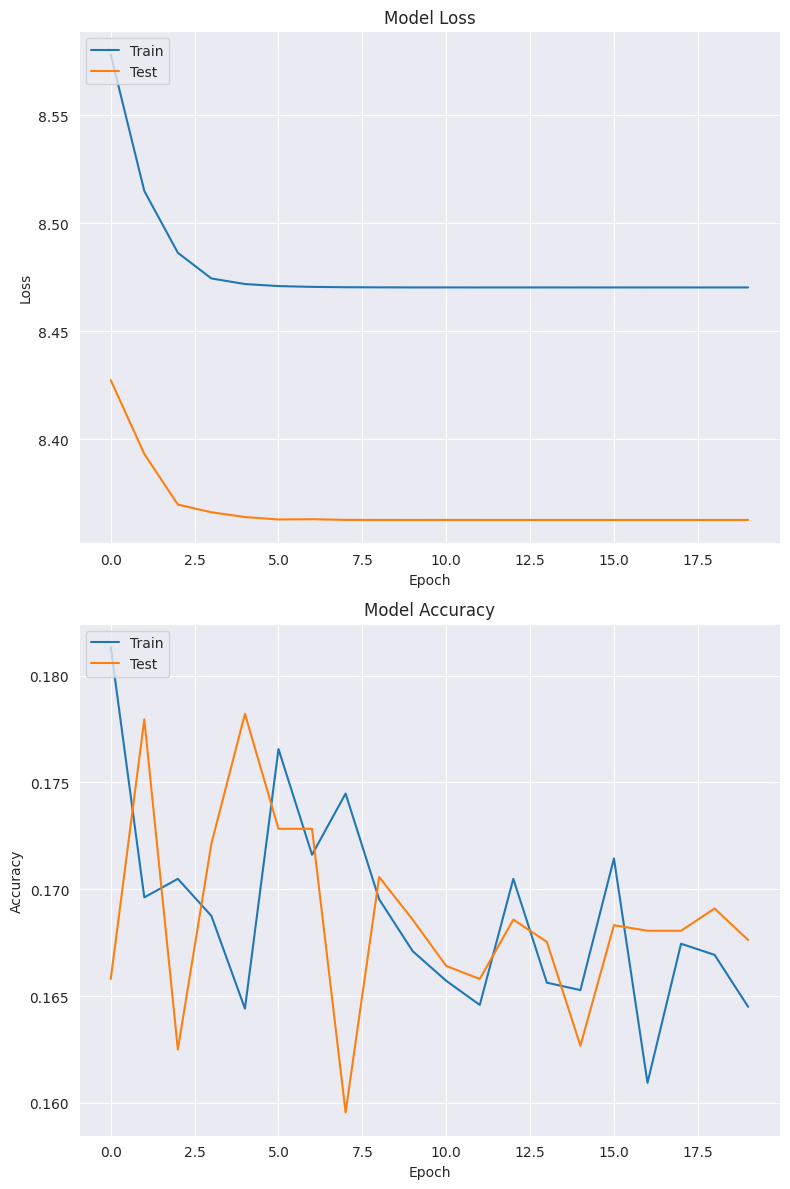

In [ ]:
nn_model = neural_network(learning_rate, decay)
history_nn = train_loop(nn_model, X_train, y_train, X_test, y_test)
model_perf_plots(history_nn, 'accuracy', 'val_accuracy')

### Multi Layer Perceptron

In [ ]:
def multilayer_perceptron(learning_rate, decay):
    # Create model
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=input_shape))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))

    # Compile model
    opt = Adam(lr=learning_rate, decay=decay)
    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=[categorical_accuracy])

    model.summary()
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1024)              191488    
                                                                 
 dense_21 (Dense)            (None, 256)               262400    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 256)               33024     
                                                                 
 dense_24 (Dense)            (None, 1024)              263168    
                                                                 
 dense_25 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_2 (Dropout)         (None, 2048)             

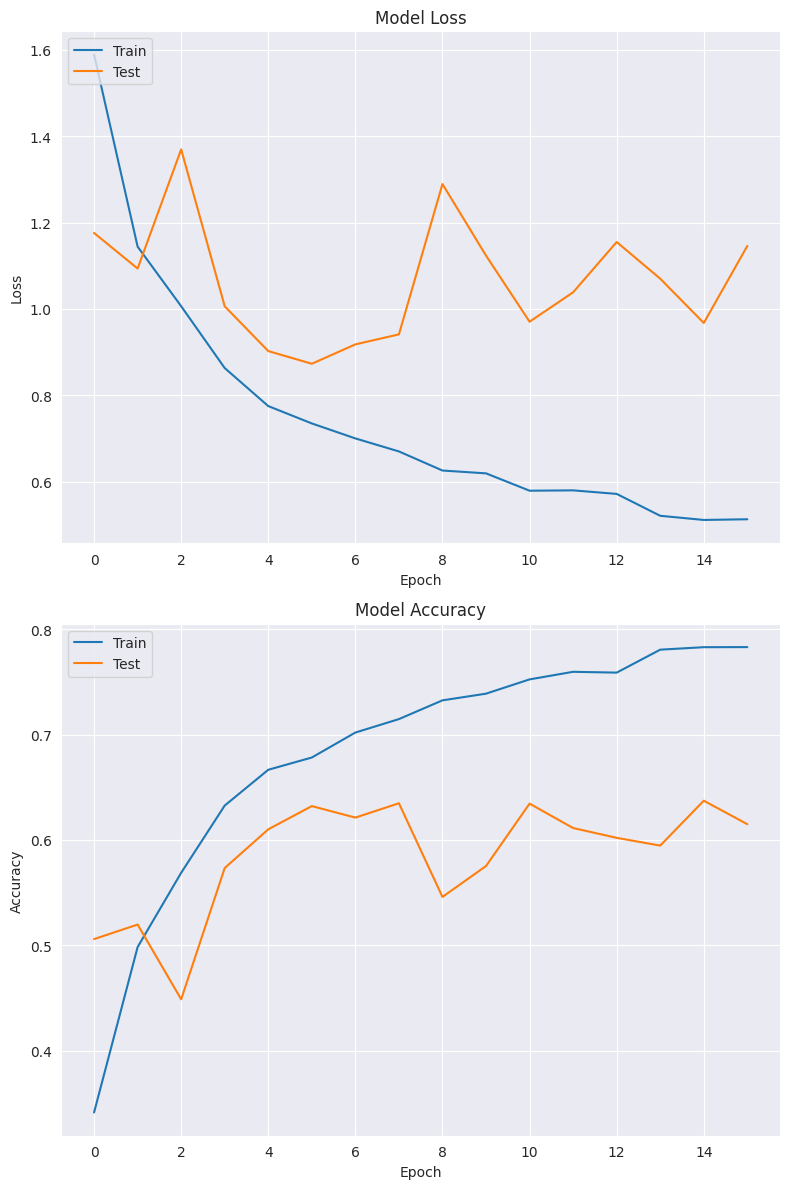

In [ ]:
mlp_model = multilayer_perceptron(learning_rate, decay)
history_mlp = train_loop(mlp_model, X_train, y_train_cat, X_test, y_test_cat, early_stopping=True)
model_perf_plots(history_mlp, 'categorical_accuracy', 'val_categorical_accuracy')

### Observations

## Temporal Transformation

In [ ]:
def temporal_tfxm(X, y):
    from keras.utils import to_categorical
    X_temp = X #[:, 0:8]
    y_temp = y.values.copy()
    # y = data[:, 9] - 1 # subtract 1 from each value in y
    num_time_steps = 320
    num_features = X_temp.shape[1]
    num_samples = len(X) // num_time_steps
    X_temp = X_temp[:num_samples * num_time_steps, :]
    X_temp = X_temp.reshape(num_samples, num_time_steps, num_features)
    y_temp = y_temp[:num_samples * num_time_steps]
    y_temp = y_temp.reshape(num_samples, num_time_steps)

    # This will create a new tensor y of shape (num_samples, num_time_steps, num_classes) 
    # where each class label is represented as a binary vector of length 7.
    y_temp = to_categorical(y_temp, num_classes=6)

    print('Transformed X Shape: ', X_temp.shape)
    print('Transformed Y Shape: ', y_temp.shape)
    return X_temp, y_temp

In [ ]:
print('Training Data Shape')
X_tem_tr, y_tem_tr = temporal_tfxm(X_train, y_train)
print('Testing Data Shape')
X_tem_ts, y_tem_ts = temporal_tfxm(X_test, y_test)
# X_tem_tr[10,1,1]

Training Data Shape
Transformed X Shape:  (36, 320, 186)
Transformed Y Shape:  (36, 320, 6)
Testing Data Shape
Transformed X Shape:  (36, 320, 186)
Transformed Y Shape:  (36, 320, 6)


In [ ]:
# y_tem_tr[:10,1,:]

## Recurrent Neural Network (RNN)

In [ ]:
from keras.layers import SimpleRNN

# Define the RNN model architecture
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(num_time_steps, num_features)))
model.add(Dense(units=7, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 32)                1312      
                                                                 
 dense_48 (Dense)            (None, 7)                 231       
                                                                 
Total params: 1,543
Trainable params: 1,543
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
model.fit(X_tem_tr, y_tem_tr, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10


ValueError: ignored

## LSTM

### Basic LSTM

In [ ]:
from keras.layers import LSTM
from keras.layers import Reshape

def simple_lstm(num_time_steps, num_features, num_classes):
    # Build the model
    model = Sequential()
    model.add(LSTM(128, input_shape=(num_time_steps, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.add(Reshape((num_time_steps, num_classes)))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary)
    return model
# # Train the model
# history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fe3fb4fd1f0>>
Epoch 1/128
1/1 [==============================] - 8s 8s/step - loss: 1.8405 - accuracy: 0.1563 - val_loss: 1.7809 - val_accuracy: 0.1978
Epoch 2/128
1/1 [==============================] - 1s 1s/step - loss: 1.7769 - accuracy: 0.2001 - val_loss: 1.7473 - val_accuracy: 0.2418
Epoch 3/128
1/1 [==============================] - 1s 1s/step - loss: 1.7352 - accuracy: 0.2490 - val_loss: 1.7244 - val_accuracy: 0.2582
Epoch 4/128
1/1 [==============================] - 1s 1s/step - loss: 1.7093 - accuracy: 0.2599 - val_loss: 1.7020 - val_accuracy: 0.2694
Epoch 5/128
1/1 [==============================] - 1s 1s/step - loss: 1.6808 - accuracy: 0.2911 - val_loss: 1.6847 - val_accuracy: 0.2799
Epoch 6/128
1/1 [==============================] - 1s 1s/step - loss: 1.6592 - accuracy: 0.2971 - val_loss: 1.6687 - val_accuracy: 0.2933
Epoch 7/128
1/1 [==============================] - 2s 2s/step - loss: 1.6360 -

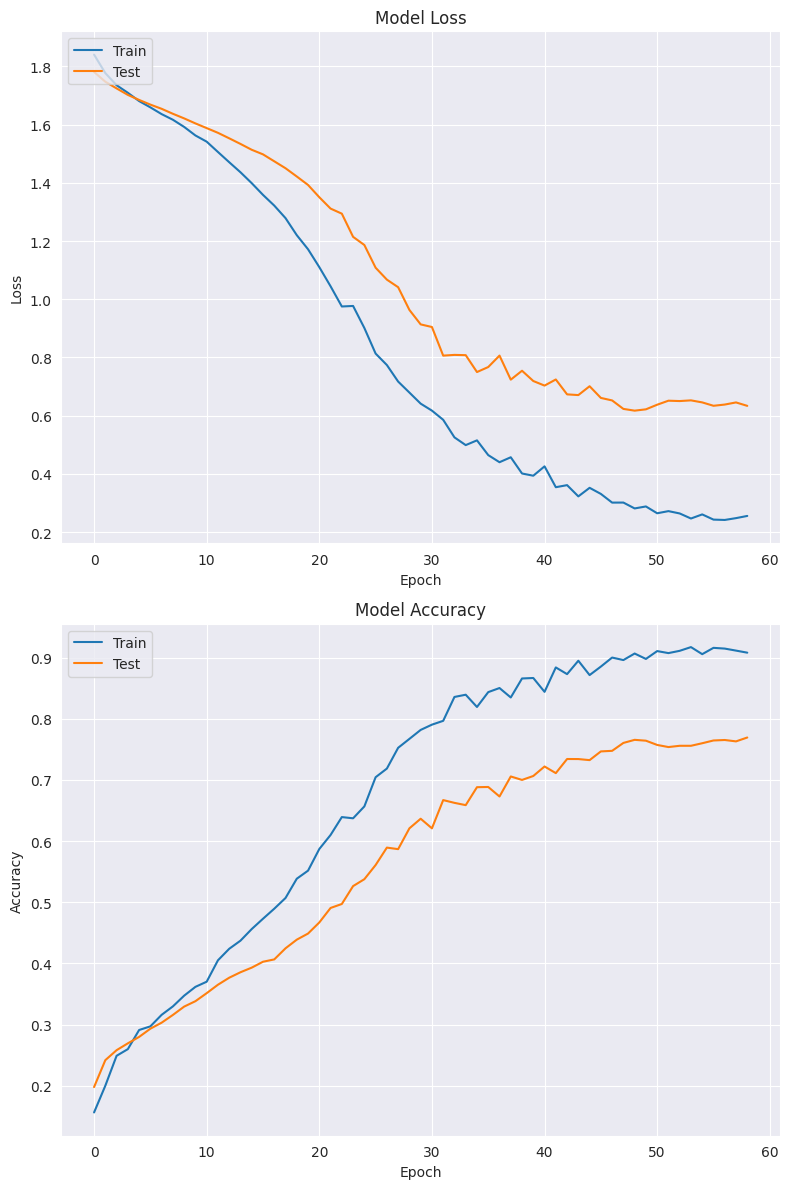

In [ ]:
slstm_model = simple_lstm(num_time_steps=320, num_features=186, num_classes=6)
history_slstm = train_loop(slstm_model, X_tem_tr, y_tem_tr, X_tem_ts, y_tem_ts)
model_perf_plots(history_slstm, 'accuracy', 'val_accuracy')

### Advanced LSTM

In [ ]:
from keras.layers import LSTM
from keras.layers import Reshape, Flatten

def adv_lstm(num_time_steps, num_features, num_classes):
    # Build the model
    model = Sequential()
    model.add(LSTM(256, input_shape=(num_time_steps, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(num_time_steps * num_classes, activation='softmax'))
    model.add(Reshape((num_time_steps, num_classes)))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 320, 256)          453632    
                                                                 
 dropout_11 (Dropout)        (None, 320, 256)          0         
                                                                 
 lstm_8 (LSTM)               (None, 320, 128)          197120    
                                                                 
 dropout_12 (Dropout)        (None, 320, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 32)               

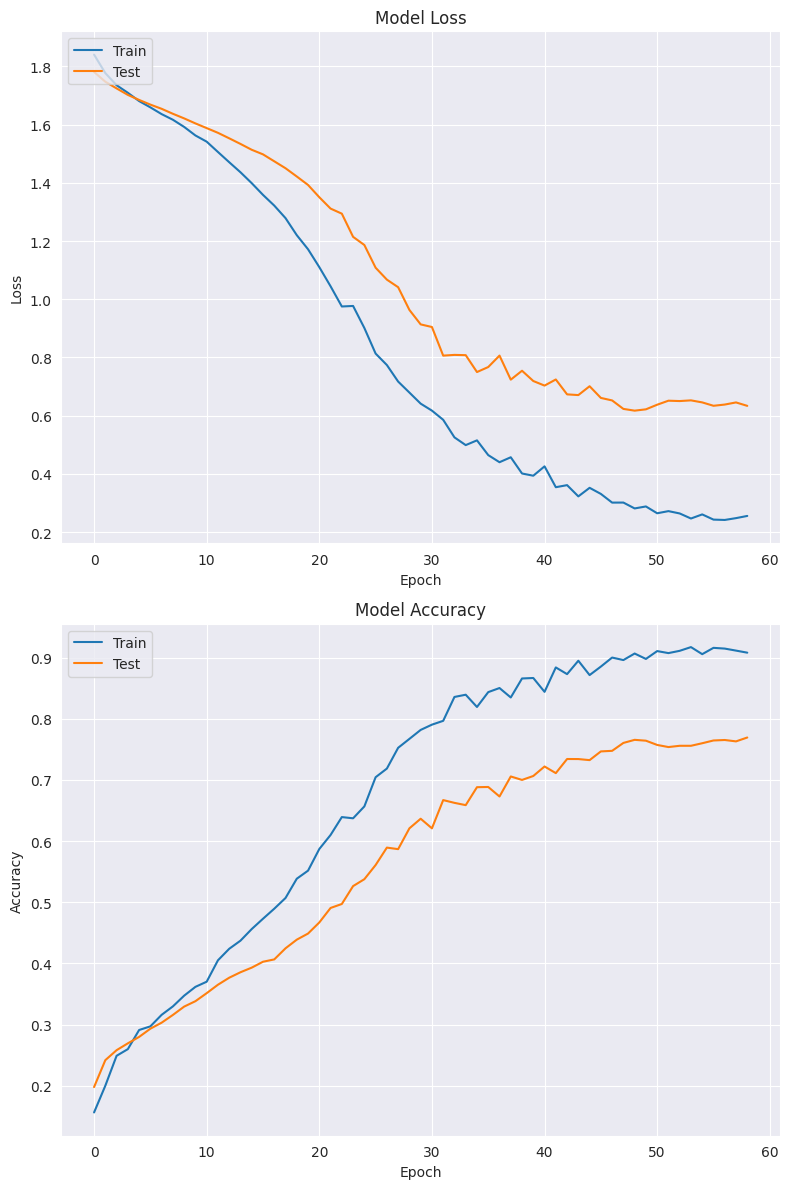

In [ ]:
alstm_model = adv_lstm(num_time_steps=320, num_features=186, num_classes=6)
history_alstm = train_loop(alstm_model, X_tem_tr, y_tem_tr, X_tem_ts, y_tem_ts)
model_perf_plots(history_slstm, 'accuracy', 'val_accuracy')

## GRU

In [ ]:
from keras.layers import GRU, TimeDistributed, Conv1D
from keras.layers import Reshape
def simple_gru(num_time_steps, num_features, num_classes):
    # Build the model
    model = Sequential()
    model.add(GRU(512, activation='relu', input_shape=(num_time_steps, num_features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.add(Reshape((num_time_steps, num_classes)))
    model.add(Reshape((-1, num_classes, 1)))
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optim = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['categorical_accuracy'])
    print(model.summary())
    return model


In [ ]:
sgru_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 512)               1075200   
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 1,078,278
Trainable params: 1,078,278
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_tem_tr2 = np.expand_dims(X_tem_tr, axis=-1)
X_tem_ts2 = np.expand_dims(X_tem_ts, axis=-1)


In [ ]:
X_tem_tr2.shape

(36, 320, 186, 1)

In [ ]:
sgru_model = simple_gru(num_time_steps=320, num_features=186, num_classes=6)
# print(X_tem_tr2.shape, y_tem_tr.shape, X_tem_ts2.shape, y_tem_ts.shape)
history_sgru = train_loop(sgru_model, X_tem_tr2, y_tem_tr, X_tem_ts2, y_tem_ts)
model_perf_plots(history_sgru, 'accuracy', 'val_accuracy')

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 320, 512)          1075200   
                                                                 
 dropout_27 (Dropout)        (None, 320, 512)          0         
                                                                 
 dense_45 (Dense)            (None, 320, 6)            3078      
                                                                 
 reshape_9 (Reshape)         (None, 320, 6)            0         
                                                                 
 reshape_10 (Reshape)        (None, 320, 6, 1)         0         
                                                                 
 time_distributed_3 (TimeDis  (None, 320, 6, 32)       128       
 tributed)                                                       
                                                     

ValueError: ignored